## **Time Series Forecasting**

Name: Ryan Yeo

Admin Number: P2214452

Class: DAAA/FT/2A/01

<hr>

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from pmdarima.arima import auto_arima

import warnings

**Goal: To train time series models and forecast the gas consumption, electricity consumption and water consumption in the future**

## Background Research

Types of Energy Consumption:
- Gas Consumption
  
  Gas consumption typically refers to the use of natural gas which is a fossil fuel. Natural Gas is a versatile energy source used for heating, cooking, electricity generation and industrial processes

- Electricity Consumption

    Electricity consumption refers to the consumption of electrical energy for various purposes most commonly lighting, heating, cooling and powering appliances. It is generated from a variety of sources such as fossil fuels, nuclear power and renewable sources such as solar, wind geothermal etc.

- Water Consumption

    Water consumption refers to the amount of water used by individuals, industries and communities for a variety of purposes. It is consumed in household for drinking, cooking, cleaning and irrigation. It also used extensively in industries for manufacuring processes and cooling systems

Forecasting these energy consumption for gas, electricity and water are essential for effective resource management, infrastructure planning     and policy development.

## 1. EDA

In [2]:
df = pd.read_csv('Energy Consumption Dataset.csv')

In [3]:
print(list(df.columns))

['DATE', 'Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']


Rename some columns

In [4]:
df.rename(columns={
'DATE': 'Date',
'Gas Consumption (tons)':'Gas', 
'Electricity Consumption (MWh)': 'Electricity',
'Water Consumption (tons)':'Water',
}, inplace=True)

In [5]:
print(f"Shape: {df.shape}")
print(df.info())

Shape: (397, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         397 non-null    object 
 1   Gas          397 non-null    float64
 2   Electricity  397 non-null    float64
 3   Water        397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB
None


**Data Dictionary**

| Column Name  | Data Type  | Definition  | 
|---|---|---|
| Date  | Date  | Year, Month and Day  |
| Gas  | Numeric  | Gas consumption in tons  |
| Electricity  | Numeric | Electricity consumption in Megawatt hour  |
| Water  |  Numeric | Water consumption in tons  |

In [6]:
print("SUMMARY STATISTICS OF NUMERIC COLUMNS")
display(df.describe().T)

SUMMARY STATISTICS OF NUMERIC COLUMNS


count        mean         std    min    25%    50%     75%  \
Gas          397.0   23.785139    4.903452   11.6   20.2   23.5    27.9   
Electricity  397.0  888.472544  153.877594  553.2  771.1  897.8  1005.2   
Water        397.0  484.953652  133.908863   44.4  384.4  487.4   580.2   

                max  
Gas            46.0  
Electricity  1294.0  
Water         811.0

Convert date column to datetiime format

In [7]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
display(df.head())

Date   Gas  Electricity  Water
0 1990-01-01  18.0        725.1  548.8
1 1990-02-01  15.8        706.7  640.7
2 1990-03-01  17.3        624.5  511.1
3 1990-04-01  18.9        574.7  515.3
4 1990-05-01  22.0        553.2  488.4

Check for missing values

In [8]:
print(df.isnull().sum())

Date           0
Gas            0
Electricity    0
Water          0
dtype: int64


Check the seasonal decomposition of all three variables

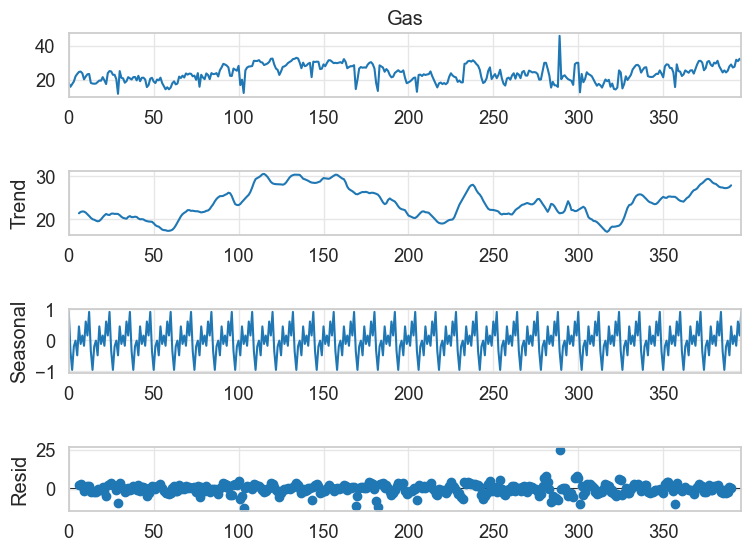

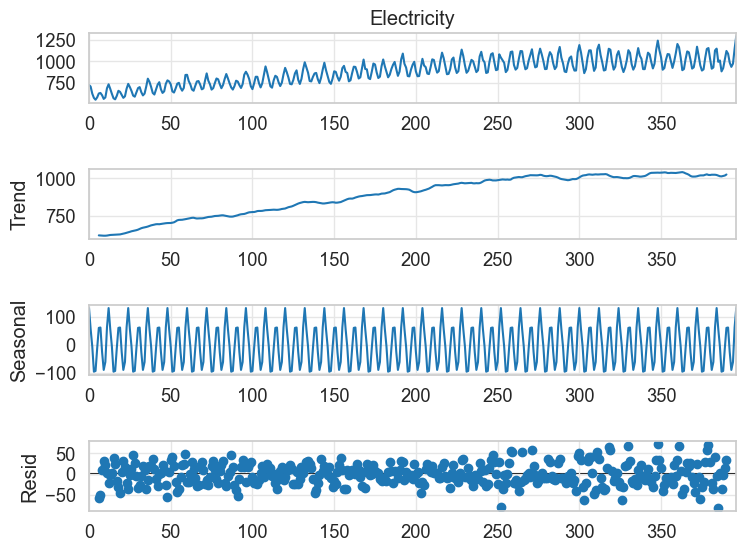

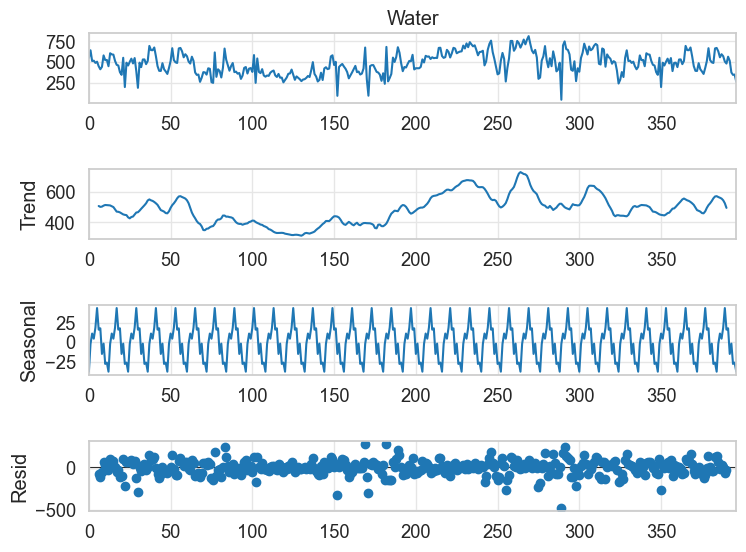

In [9]:
sns.set_context('notebook', font_scale=1.2)

# Set grid
sns.set_style('whitegrid', {'grid.color': '0.9'})

# Gas 
# Plot and adjust figure size
gas_decomp = seasonal_decompose(df['Gas'], model='additive', period=12)
fig = gas_decomp.plot()
fig.set_size_inches(8, 6)

# Electricity
# Plot and adjust figure size
elec_decomp = seasonal_decompose(df['Electricity'], model='additive', period=12)
fig = elec_decomp.plot()
fig.set_size_inches(8, 6)

# Water
# Plot and adjust figure size
water_decomp = seasonal_decompose(df['Water'], model='additive', period=12)
fig = water_decomp.plot()
fig.set_size_inches(8, 6)

**Observations**:
- From the seasonal decomposition plots, the residuals are random for all three time series which indicates that there are no patterns among the residuals
- From the trend component, it seems that Gas and Water have no obvious trend while Electricity has an upward trend as time goes by

## 2. **Stationarity Check**

Stationarity describes that the time-series has:
- Constant mean that does not vary with time
- Constant variance that does not vary with time
- Constant covariance that does not vary with time

Stationarity is important in time series since some models such as ARIMA assumes that the underlying data is stationary.

There are three different types of stationary series:
1. Strict Stationary
2. Seasonal Stationary
3. Trend Stationary

In order to test if a time series is stationary and to test the kind of stationarity, we can use several methods:
- Visual Test
- Basic Check for mean, variance and covariance
- Statistical Tests

#### **Visual Test**

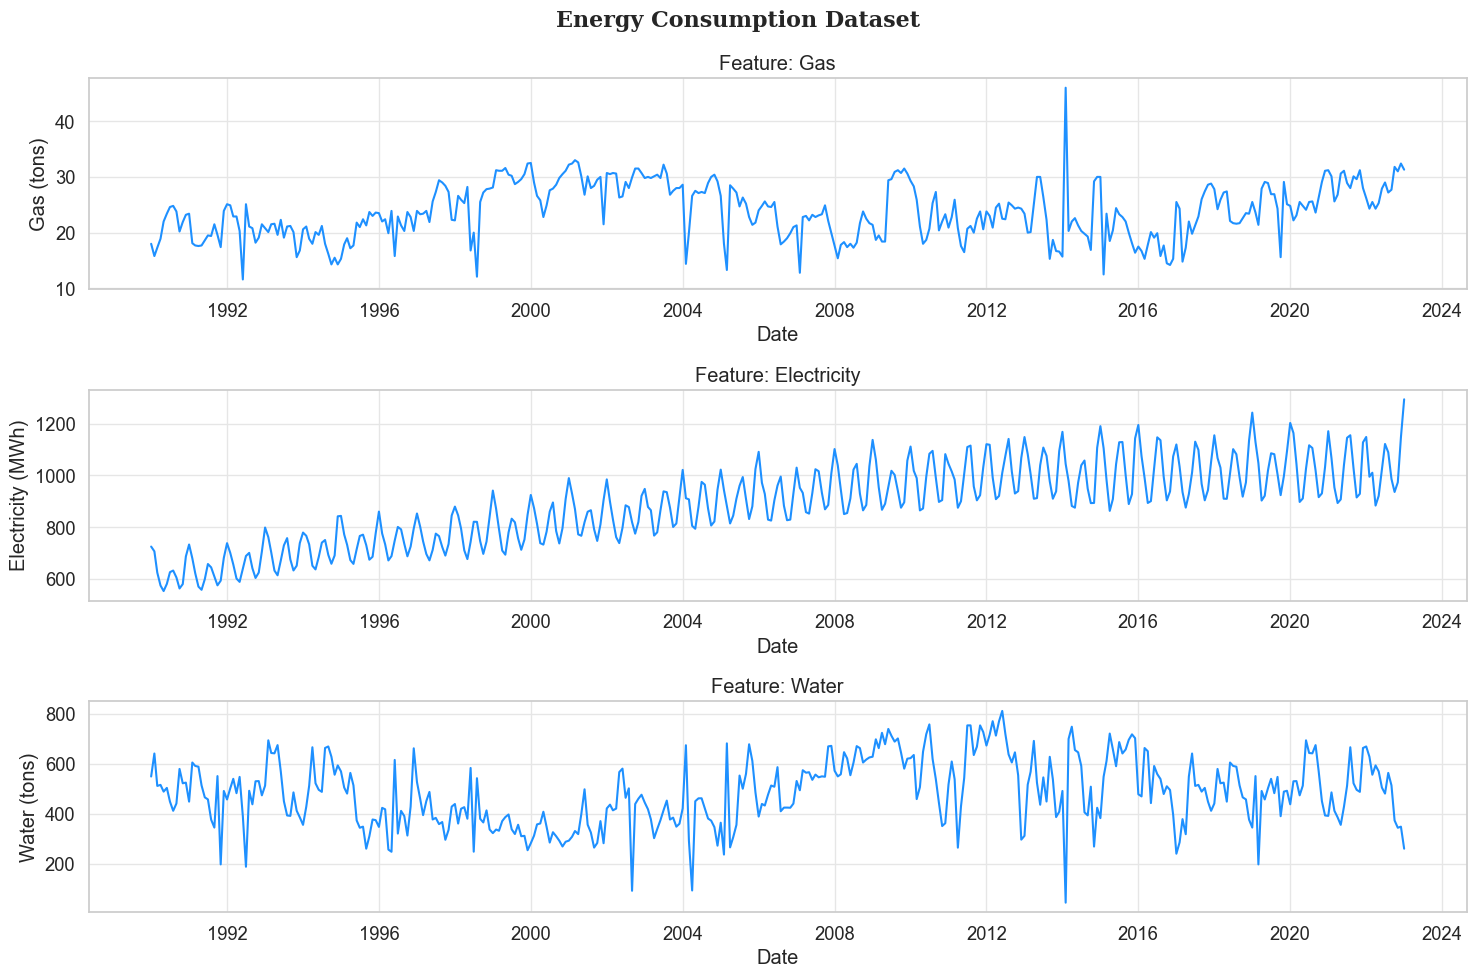

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
sns.set_context('notebook', font_scale=1.2)

# Set grid
sns.set_style('whitegrid', {'grid.color': '0.9'})

units = ['tons', 'MWh', 'tons']

cols = df.drop('Date', axis=1).columns

for i, col in enumerate(cols):
    sns.lineplot(x=df['Date'], y=df[col], ax=ax[i], color='dodgerblue')
    ax[i].set_title(f"Feature: {col}")
    ax[i].set_ylabel(f"{col} ({units[i]})")

# Set subtitle
fig.suptitle("Energy Consumption Dataset", fontsize=16, fontweight='bold', fontfamily='serif')

plt.tight_layout()

plt.show()

**Observations**:
- It seems that there is a trend for the Electricity time series which suggests that it is not stationary since its mean is not constant
- There seems to be no discernable trend for the Gas and Water time series which suggests that it might be stationary. 
- However, we need to perform further checks to verify these claims

#### **Basic Check for mean, variance**

By splitting the sample into two and checking each sample for its mean and variance. For a stationary time series, the mean and variance for both samples should be roughly similar. However, for a time series that is not stationary, the mean and variance would be quite different

In [11]:
def SummaryStatistics(df, col):
    sample1 = df.iloc[:int(len(df)/2)]
    sample2 = df.iloc[int(len(df)/2):]
    res = col
    res += f"\n\nSample 1"
    res += f"\nMean: {sample1[col].mean():.2f}"
    res += f"\nVariance: {sample1[col].var():.2f}"
    res += f"\n\nSample 2"
    res += f"\nMean: {sample2[col].mean():.2f}"
    res += f"\nVariance: {sample2[col].var():.2f}"
    return res

In [12]:
for col in cols:
    print(SummaryStatistics(df, col) + '\n')

Gas

Sample 1
Mean: 24.28
Variance: 24.48

Sample 2
Mean: 23.29
Variance: 23.23

Electricity

Sample 1
Mean: 774.04
Variance: 12208.96

Sample 2
Mean: 1002.33
Variance: 9083.62

Water

Sample 1
Mean: 426.87
Variance: 13118.77

Sample 2
Mean: 542.75
Variance: 16079.41



**Observations**:
- Gas
  - Quite similar Mean and Variance suggesting that the time series is stationary
- Electricity
  - Quite hard to tell if the mean is similar but the variance is very different with the variance of sample 1 being almost two times that of sample 2 suggesting that the time series is not stationary
  - This wsuggests that the time series for electricity shows changing variance over time and we will have to stabilize the variance later on
- Water
  - Quite hard to tell if the mean is similar but the variance is quite similar
  - This might suggest that the time series is either trend stationary or difference stationary

#### **Statistical Tests**

<ins>**Augmented Dickey-Fuller (ADF Test)**</ins>

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. In statistics, a unit root is a feature that can cause problems in statistical inference involving time series models.

The presence of a unit root means that the time series is non-stationary.

$H_{0}:$ Time Series has a unit root (Time Series is not stationary)

$H_{1}:$ Time Series has no unit root (Time Series is stationary)


In [13]:
def ADF(df, col, ALPHA='5%'):
    result = adfuller(df[col])
    res = f"{'-'*100}\nADF Test for {col}\n{'-'*100}\nADF Statistic: {result[0]:.2f}\np-value: {result[1]:.2f}\nCritical Values:\n"

    for key, value in result[4].items():
        res += f'   {key}: {value:.2f}\n'

    # If its in the critical region, then reject the null hypothesis (series has no unit root)
    if result[0] < result[4][ALPHA]:
        res += f"\nThe time series is stationary\n"
    # Else, accept the null hypothesis (series has a unit root)
    else:
        res += f"\nThe time series is not stationary\n"

    res+='-'*100
    return res

In [14]:
for col in cols:
    print(ADF(df, col) + '\n\n')

----------------------------------------------------------------------------------------------------
ADF Test for Gas
----------------------------------------------------------------------------------------------------
ADF Statistic: -3.40
p-value: 0.01
Critical Values:
   1%: -3.45
   5%: -2.87
   10%: -2.57

The time series is stationary
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
ADF Test for Electricity
----------------------------------------------------------------------------------------------------
ADF Statistic: -2.26
p-value: 0.19
Critical Values:
   1%: -3.45
   5%: -2.87
   10%: -2.57

The time series is not stationary
----------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------------------------

**Observations**:
- *Gas*
    - p-value = 0.01 < $\alpha = 0.05$
    - test-statistic = -3.40 and is in the rejection region since the critical value is -2.87
    - $\therefore H_0$ is rejected at $\alpha = 0.05$ and the time series for gas has no unit root. This suggests that the time series for gas is stationary
- *Electricity*
  - p-value = 0.19 > $\alpha = 0.05$
  - test-statistic = -2.26 and is not in the rejection region since the criticial value is -2.87
  - $\therefore$ there is insufficient evidence to reject $H_0$ at $\alpha = 0.05$ and the time series for electricity has a unit root. This suggests that the time series for gas is not stationary
- *Water*
    - p-value $\approx$ 0.00 < $\alpha = 0.05$
    - test-statistic = -4.68 and is in the rejection region since the critical value is -2.87
    - $\therefore H_0$ is rejected at $\alpha = 0.05$ and the time series for water has no unit root. This suggests that the time series for water is stationary

<ins>**Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**</ins>

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

$H_{0}:$ The process is trend stationary

$H_{1}:$ The series has a unit root (series is not stationary)

In [15]:
def KPSS(df, col, ALPHA='5%'):
    result = kpss(df[col])
    res = f"{'-'*100}\nKPSS Test for {col}\n{'-'*100}\nKPSS Statistic: {result[0]:.2f}\n\nCritical Values:\n"
    
    for key, value in result[3].items():
        res += f'   {key}: {value:.2f}\n'

    # If its in the critical region, then reject the null hypothesis (series is not stationary)
    if result[0] > result[3][ALPHA]:
        res += f"\nThe time series is not stationary\n"
    # Else, accept the null hypothesis (series is stationary)
    else:
        res += f"\nThe time series is stationary\n"
    res+='-'*100
    return res

In [16]:
warnings.filterwarnings('ignore')

for col in cols:
    print(KPSS(df, col) + '\n\n')

----------------------------------------------------------------------------------------------------
KPSS Test for Gas
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.34

Critical Values:
   10%: 0.35
   5%: 0.46
   2.5%: 0.57
   1%: 0.74

The time series is stationary
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
KPSS Test for Electricity
----------------------------------------------------------------------------------------------------
KPSS Statistic: 3.53

Critical Values:
   10%: 0.35
   5%: 0.46
   2.5%: 0.57
   1%: 0.74

The time series is not stationary
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------

**Observations**:
- *Gas*
    - test-statistic = 0.34 and is not in the rejection region since the critical value is 0.46
    - $\therefore$ there is insufficient evidence to reject $H_0$ at $\alpha = 0.05$ and the time series for gas is trend stationary.
- *Electricity*
  - test-statistic = 3.53 and is in the rejection region since the critical value is 0.46
  - $\therefore H_0$ is rejected at $\alpha = 0.05$ and the time series for electricity has a unit root. This suggests that the time series for electricity is not stationary
- *Water*
    - test-statistic = 0.84 and is in the rejection region since the critical value is 0.46
    - $\therefore H_0$ is rejected at $\alpha = 0.05$ and the time series for water has a unit root. This suggests that the time series for water is not stationary

There are several possible outcomes after applying both stationary tests:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is trend stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary (mean trend is deterministic)
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series  is difference stationary (mean trend is stochastic)

- Gas
  - Since both tests conclude that the series is stationary, the series is stationary
- Electricity
  - Since both tests conclude that the series is not stationary, the series is not stationary. This means that the series has to be differenced before checking for stationarity
- Water
  - Since KPSS indicates non-stationarity and ADF indicates stationarity, the series is difference stationarity. The differenced series can then be checked for stationarity

### **Differencing**

Differencing a process commonly used to convert a non-stationary time series into a stationary one by removing the trend component. It involves subtracting the current value of the series from the previous one

<ins>Formula for first order differencing</ins>:

$\begin{equation}
y^{'}_{t} = y_{t} - y_{t-1}
\nonumber
\end{equation}$

where $y_{t}$ is the value of the time series at time t and $y^{'}_{t}$ is the value of the differenced time series at time t

**First Order Differencing**

Since the time series for Gas is already stationary, we will not need to difference it. Instead we will be differencing the logged transformed Electricity and the Water time series and check if it is stationary using ADF and KPSS again 

In [17]:
df['Electricity_diff1'] = df['Electricity'].diff().fillna(0)
print(SummaryStatistics(df, 'Electricity_diff1'))

print('\n\n')

df['Water_diff1'] = df['Water'].diff().fillna(0)
print(SummaryStatistics(df, 'Water_diff1'))

Electricity_diff1

Sample 1
Mean: 0.90
Variance: 3834.02

Sample 2
Mean: 1.96
Variance: 8211.36



Water_diff1

Sample 1
Mean: -0.21
Variance: 14141.91

Sample 2
Mean: -1.24
Variance: 12539.18


In [18]:
print(ADF(df, 'Electricity_diff1'))
print(KPSS(df, 'Electricity_diff1'))
print('\n')
print(ADF(df, 'Water_diff1'))
print(KPSS(df, 'Water_diff1'))

----------------------------------------------------------------------------------------------------
ADF Test for Electricity_diff1
----------------------------------------------------------------------------------------------------
ADF Statistic: -7.09
p-value: 0.00
Critical Values:
   1%: -3.45
   5%: -2.87
   10%: -2.57

The time series is stationary
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
KPSS Test for Electricity_diff1
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.15

Critical Values:
   10%: 0.35
   5%: 0.46
   2.5%: 0.57
   1%: 0.74

The time series is stationary
----------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------

**Observations**:
- After one round of differencing, both ADF and KPSS conclude that the time series are now stationary

### **Prework for ARMA**

Now that all three time series are stationary, we can try to fit a model to try and forecast the energy consumption.

<ins>**Autocorrelation Function (ACF)**</ins>

Autocorrelation Function (ACF) is a correlation coefficient. However, instead of measuring the correlation between two seperate variables, it measures the correlation between the same variable at time $X_t$ and $X_{t+h}$ i.e. correlation with lag-h 




$\begin{equation}
ACF = Corr(X_{t+h}, X_{t})
\nonumber
\end{equation}$

<ins>**Partial Autocorrelation Function (PACF)**</ins>

Partial Autocorrelation Function (PACF) is the correlation between two observations at two time spots given that both observations are correlated to observvations at other time spots. The partial autocorrelation at lag k is the autocorrelation between $X_t$ and $X_{t-k}$ that is not accounted for by lags 1 through k-1






To determine the order of p and q, we can use this table

| ACF  | PACF | Model |
| ------------- | ------------- | --------------- |
| Tailoff  | Order of p  | AR(p)
| Order of q  | Tailoff  | MA(q)
| Tailoff | Tailoff | ARMA (p,q)

In [19]:
# Plot ACF and PACF 

def plot_acf_pacf(df, col, ax=None, lags=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    fig = plt.suptitle(f"ACF and PACF of {col}", fontsize=16, fontweight='bold', fontfamily='serif')


    plot_acf(df[col], ax=ax[0], lags=lags)
    plot_pacf(df[col], ax=ax[1], lags=lags, method='ywm')

    return ax

#### *1. Gas*

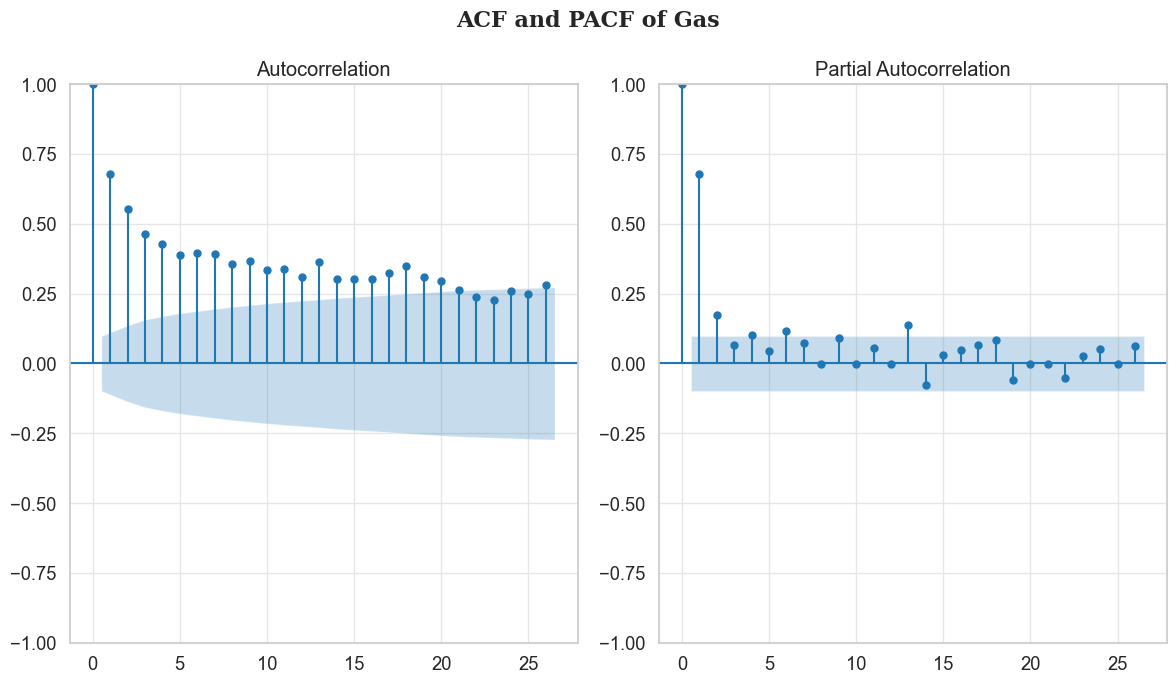

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
plot_acf_pacf(df, 'Gas', ax=ax)
plt.tight_layout()
plt.show()

**Observations**:
- From the ACF plot, it seems that the autocorrelations are significant for a large number of lags. 
- However, it may be that the autocorrelations at lags 2 and above are due to the propagaion of the autocorrelation at lag 1. This is confirmed by the PACF plot which only has a significant spike at lag 1 meaning that all the higher order autocorrelation are effectively explained by the lag-1 autocorrelation.

Essentially, this means that GAS has to be differenced to be stationarized.

In [21]:
df['Gas_diff1'] = np.append([0], np.diff(df['Gas']))
print(SummaryStatistics(df, 'Gas_diff1'))

print(ADF(df, 'Gas_diff1'))
print(KPSS(df, 'Gas_diff1'))

Gas_diff1

Sample 1
Mean: 0.04
Variance: 10.98

Sample 2
Mean: 0.03
Variance: 19.52
----------------------------------------------------------------------------------------------------
ADF Test for Gas_diff1
----------------------------------------------------------------------------------------------------
ADF Statistic: -7.84
p-value: 0.00
Critical Values:
   1%: -3.45
   5%: -2.87
   10%: -2.57

The time series is stationary
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
KPSS Test for Gas_diff1
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.09

Critical Values:
   10%: 0.35
   5%: 0.46
   2.5%: 0.57
   1%: 0.74

The time series is stationary
----------------------------------------------------------------------------------------------------


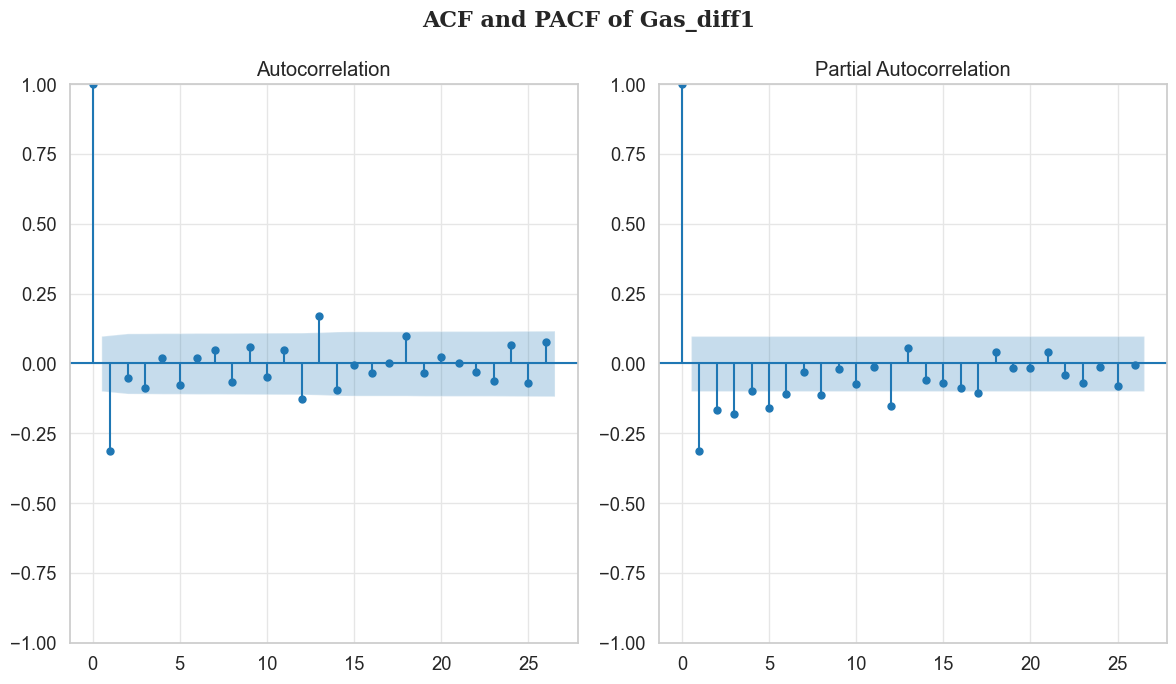

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

plot_acf_pacf(df, 'Gas_diff1', ax=ax)
plt.tight_layout()
plt.show()

**Observaions**:
- It seems that the correlation at lag 1 is significant and positive for both plots
- The ACF shows a sharper cutoff compared to PACF. In particular, ACF has 1 significant spike while PACF has 6
- This means that the differenced series displays a MA(1) signature which suggests that we should set the order of q to be 1 => i.e. fit an ARIMA (0,1,1) model

#### *2. Electricity*

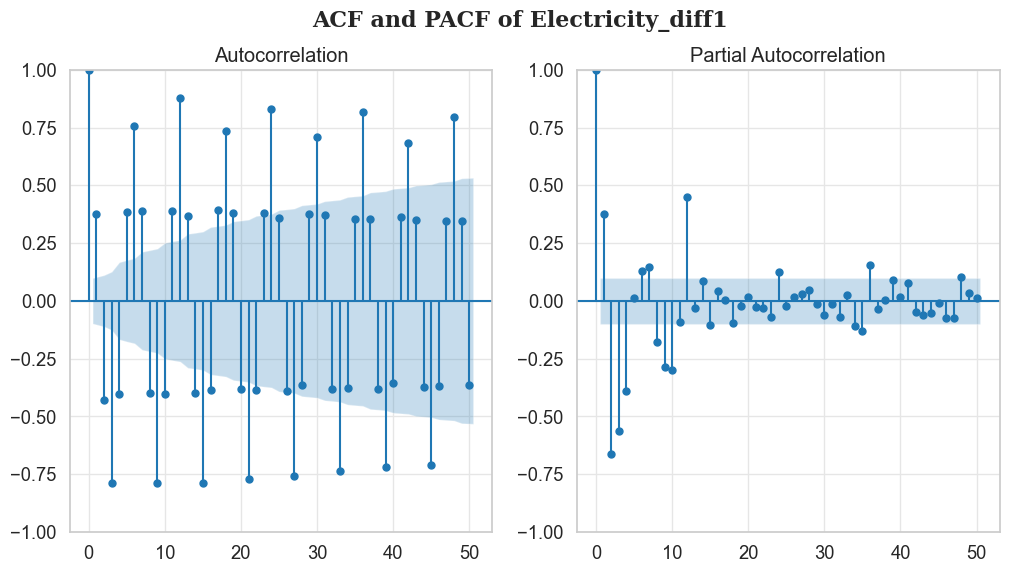

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_acf_pacf(df, 'Electricity_diff1',lags=50, ax=ax)

plt.show()

**Observations**:
- From the ACF plot, we can see a seasonal component form for Electricity
- We can test if a seasonal component is present for Electricity

First let us take a look at the seasonal decomposition of the differenced time series

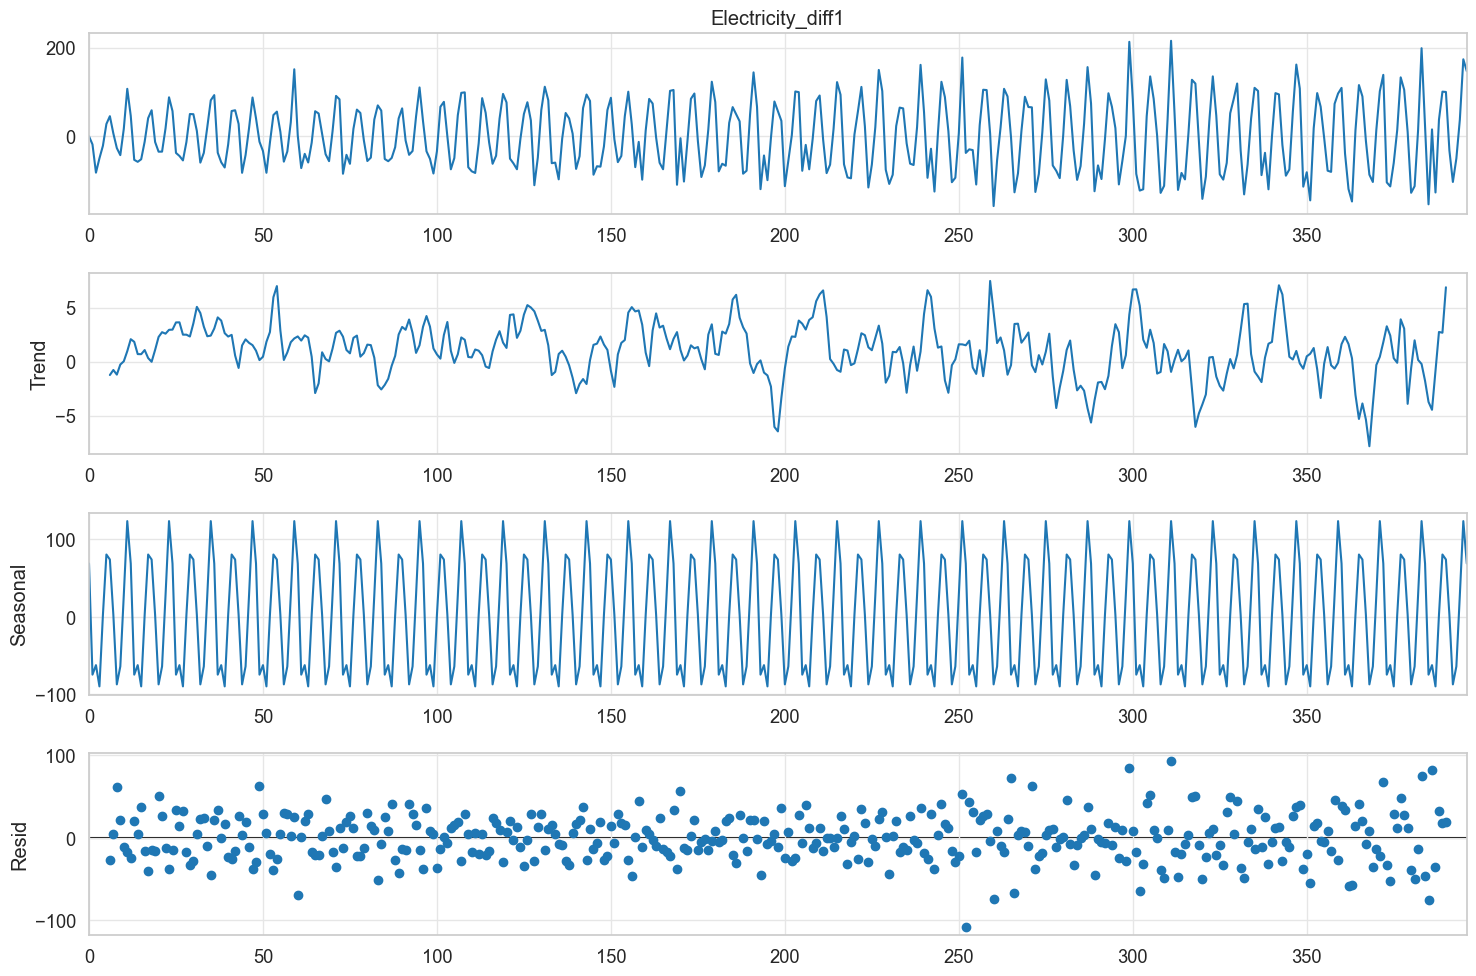

In [24]:
result = seasonal_decompose(df['Electricity_diff1'], model='additive', period=12)
fig = result.plot()
sns.set_context('notebook', font_scale=1.2)

# Increase figure size
fig.set_figwidth(15)
fig.set_figheight(10)

plt.tight_layout()
plt.show()

As seen from the chart, the trend component has been removed during differencing. The residuals also appear to be random. 
As such, we can try to identify the seasonal component of electricity. There are several methods to do this:

<ins>**ACF and PACF plots**</ins>

By plotting the ACF and PACF plots, we can try to identify the seasonal component. In order to get a bigger picture, we can try to increase the number of lags for the ACF and PACF plots and try to guess the seasonal component from there

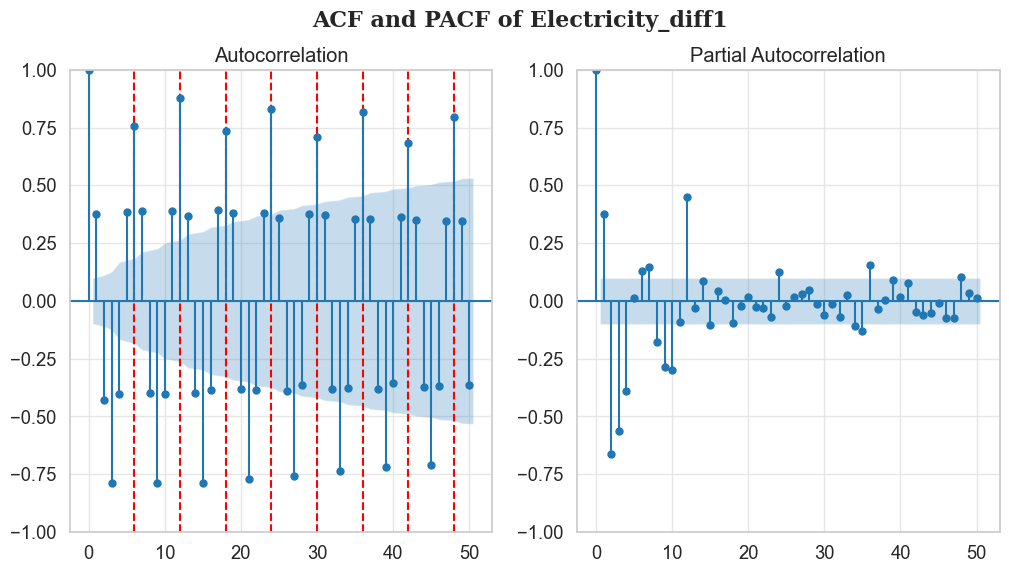

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot a red vertical line at lags multiple of 6 for ACF
for i in range(6,50,6):
    ax[0].axvline(x=i, linestyle='--', color='red')

plot_acf_pacf(df, 'Electricity_diff1', lags=50, ax=ax)

plt.show()

**Observations**:
- The ACF shows a seasonal trend with peaks every 6 months at about 6, 12, 18, 24 etc.
- Another interesting thing to note is that the peaks which are multiples of 12 (12,24,36) are higher than those that are multiples of 6 but not multiples of 12 (6,18,30). This can also suggest that the seasonal trend is at every 12 months instead of at every 6 months

<ins>**Power Spectrum Density (Fourier Transformation)**</ins>

The power spectrum is the discrete fourier transformation of the autocovariance function i.e. it is the frequency-domain counterpart of the time domain autocovariance function.

The power spectrum is used to examine the main characteristics of the time series and can be used to detect periods of seasonality if it is present in the data

First we can use Fast Fourier Transform of the autocovariance function to calculate the dominant period of seasonality

In [26]:
# Calculate using Fast Fourier Transform (FFT) the frequency spectrum of the time series

# Calculate the Fourier transform
yf = np.fft.fft(df['Electricity_diff1'])
xf = np.linspace(0.0, 1.0/(2.0), len(df['Electricity_diff1'])//2)

# Find the dominant frequency
# We have to drop the first element of the fft as it corresponds to the 
# DC component or the average value of the signal
idx = np.argmax(np.abs(yf[1:len(df['Electricity_diff1'])//2]))
freq = xf[idx]

period =(1/freq)
# In months since our data is monthly
print(f"The period of the time series is {period} months")

The period of the time series is 6.061538461538461 months


We can also view it graphically by plotting a periodogram

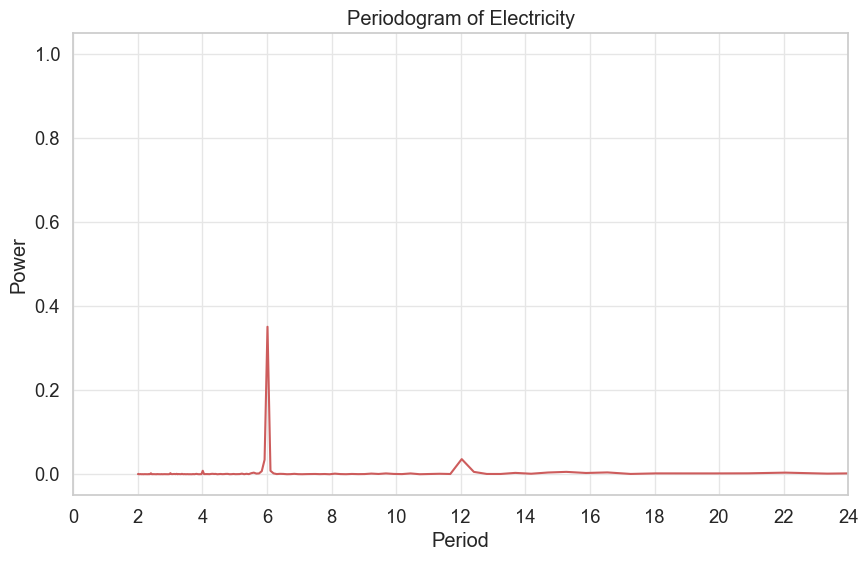

In [27]:
data = df['Electricity']
# Check for seasonality

from scipy.signal import periodogram

# Plot Periodogram
freq, power = periodogram(data)
plt.figure(figsize=(10, 6))

period = 1/freq
# Normalize the power
power = power / power.max()
plt.plot(period, power, color='indianred')

plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 2))
plt.xlabel('Period')
plt.ylabel('Power')
plt.title('Periodogram of Electricity')
plt.show()


**Observations**:
- From the periodogram, we can see that the most dominant seasonal component is at m=6 as indicated by the calculation using fast fourier transform
- However, there also exists another seasonal component at m=12

<ins>**Standard Deviation**</ins>

According to an [article](https://people.duke.edu/~rnau/411arim2.htm#:~:text=If%20the%20series%20still%20exhibits,a%20higher%20order%20of%20differencing) from Duke University, the optimal order of differencing is often the order of differencing at which the standard deviation is the lowest. 

By performing seasonal differencing with different periods and evaluating the standard deviation at each period, we can estimate the seasonal component of electricity

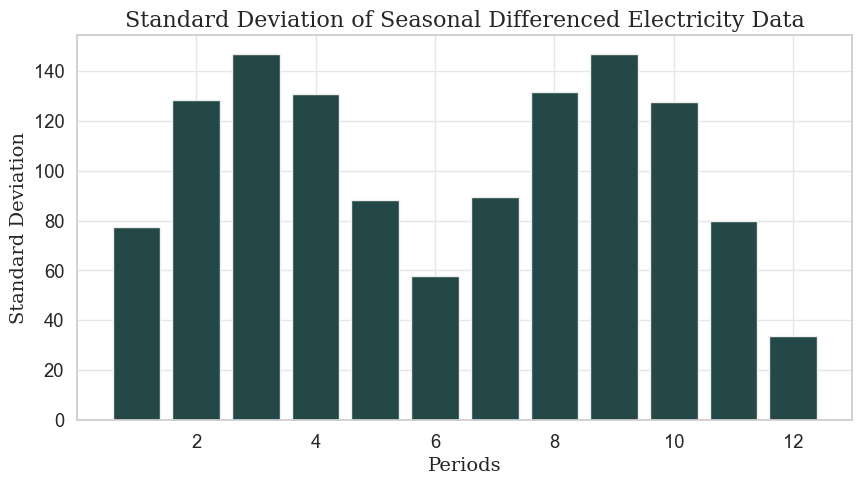

In [28]:
m_array = np.arange(1,13)
std_array = np.array([])

for m in m_array:
    seasonal_differenced = df['Electricity'].diff(periods=m).fillna(0)
    # Calculate standard deviation
    std = seasonal_differenced.std()
    std_array = np.append(std_array, std)

# Plot bar chart of standard deviation
plt.figure(figsize=(10,5))
plt.bar(m_array, std_array, color='#244747', edgecolor='#eeeeee')
plt.xlabel('Periods', fontsize=14, fontfamily='serif')
plt.ylabel('Standard Deviation', fontsize=14, fontfamily='serif')
plt.title('Standard Deviation of Seasonal Differenced Electricity Data', fontsize=16, fontfamily='serif')

plt.show()

**Observations**:
- By calculating the standard deviation at different periods, it seems that the optimal order of differencing is seasonal differencing with a period of 12 with the second best order of differencing being seasonal differencing with a period 6

Since we were not able to get any conclusive results for which period to use for our seasonal component from the different tests, we can try to fit two different SARIMA models for electricity (one with m=6 and another with m=12) and try to see which model would better fit the data and have a greater performance

In [29]:
# Perform Seasonal Differencing
df['Electricity_sdiff6'] = df['Electricity'].diff(periods=6).fillna(0)
df['Electricity_sdiff12'] = df['Electricity'].diff(periods=12).fillna(0)

Let us check if performing one order of seasonal differencing makes our Electricity time series stationary.
If it does, then there is no need to perform another order of normal differencing

In [30]:
print(ADF(df, 'Electricity_sdiff6'))
print(KPSS(df, 'Electricity_sdiff6'))

print('\n')

print(ADF(df, 'Electricity_sdiff12'))
print(KPSS(df, 'Electricity_sdiff12'))

----------------------------------------------------------------------------------------------------
ADF Test for Electricity_sdiff6
----------------------------------------------------------------------------------------------------
ADF Statistic: -6.67
p-value: 0.00
Critical Values:
   1%: -3.45
   5%: -2.87
   10%: -2.57

The time series is stationary
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
KPSS Test for Electricity_sdiff6
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.06

Critical Values:
   10%: 0.35
   5%: 0.46
   2.5%: 0.57
   1%: 0.74

The time series is stationary
----------------------------------------------------------------------------------------------------


-----------------------------------------------------------------------------------

As seen from the statistical tests, doing one order of seasonal differencing is enough to make the time series stationary for m=6. However, for m=12, the time series is still not stationary. We can make it stationary by performing another order of normal differencing

In [31]:
df['Electricity_sdiff12'] = df['Electricity_sdiff12'].diff().fillna(0)

print(ADF(df, 'Electricity_sdiff12'))
print(KPSS(df, 'Electricity_sdiff12'))

----------------------------------------------------------------------------------------------------
ADF Test for Electricity_sdiff12
----------------------------------------------------------------------------------------------------
ADF Statistic: -8.13
p-value: 0.00
Critical Values:
   1%: -3.45
   5%: -2.87
   10%: -2.57

The time series is stationary
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
KPSS Test for Electricity_sdiff12
----------------------------------------------------------------------------------------------------
KPSS Statistic: 0.08

Critical Values:
   10%: 0.35
   5%: 0.46
   2.5%: 0.57
   1%: 0.74

The time series is stationary
----------------------------------------------------------------------------------------------------


After performing one order of normal differencing, the m=12 seasonally differenced time series also becomes stationary

<ins>*ACF and PACF for m=6*</ins>

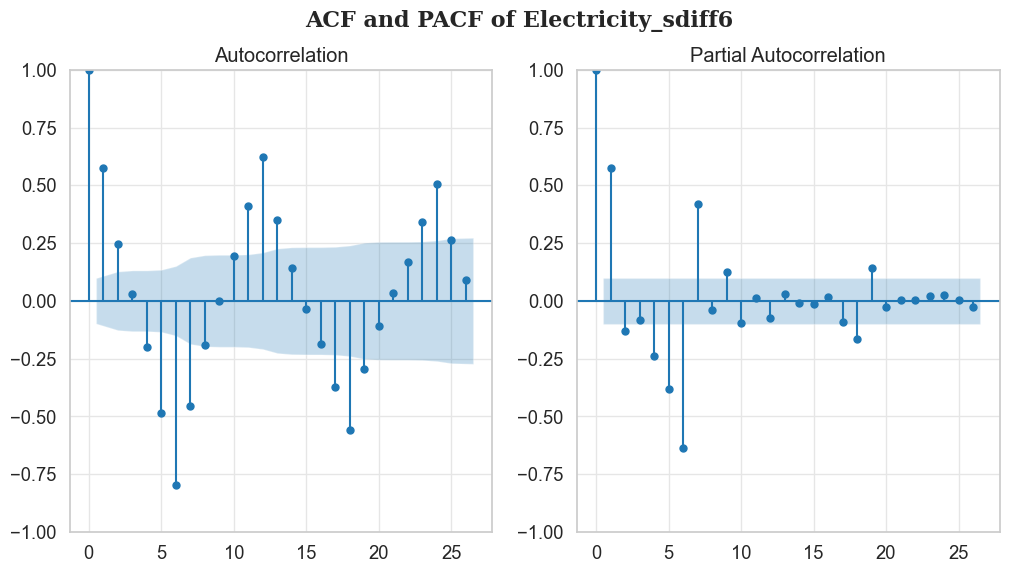

In [32]:
# Plot ACF and PACF for the time series
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_acf_pacf(df, 'Electricity_sdiff6', ax=ax)

plt.show()

**Observations**:
- Even after seasonal differencing with m=6, the ACF plot still shows a sinusodial pattern that persists.
-  This can indicate that the wrong order of differencing has been used and it might not have successfully captured the complexity of the data. 

As such, choosing a seasonal component of every 6 months might not be the best option and it might just be better to build a SARIMAX model with a seasonal component of every 12 months

<ins>*ACF and PACF for m=12*</ins>

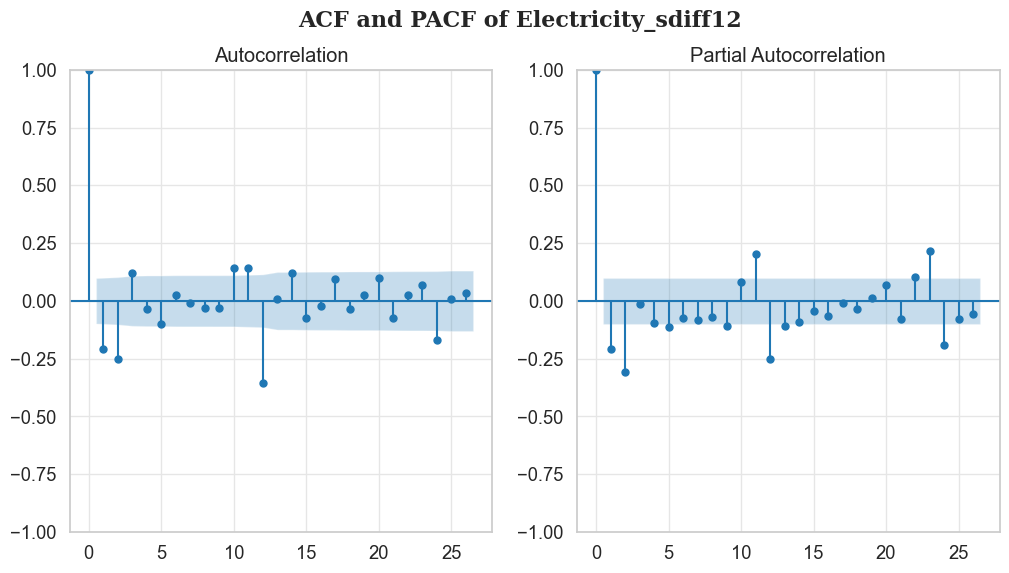

In [33]:
# Plot ACF and PACF for the time series
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_acf_pacf(df, 'Electricity_sdiff12', ax=ax)

plt.show()

**Observaions**:
- It seems that the correlation at lag 2 is significant and positive for both plots
- The ACF shows a sharp cutoff after lag 3 while the PACF shows a sharp cutoff after lag 2
- This means that the differenced series displays an AR(2) signature and a MA(3) signature which suggests that we should set the order of p to be 2 and the order of q to be 3 => i.e. use an order of (2,1,3)
- [In order to get the seasonal component](https://people.duke.edu/~rnau/seasarim.htm), we can look at the ACF plot for the autocorrelation at the seasonal period (i.e. at lag 12). If the seasonal period is positive, we can add an SAR term while if the seasonal period is negative, we can add an SMA term. Since our autocorrelation at lag 12 is negative, the time series displays an SMA(1) signature => i.e. use a seasonal order of (0, 1, 1) 
- Hence, we should fit a SARIMA model with order (2, 1, 3) and a seasonal order of (0, 1, 1) with a seasonality component of m=12

#### *3. Water*

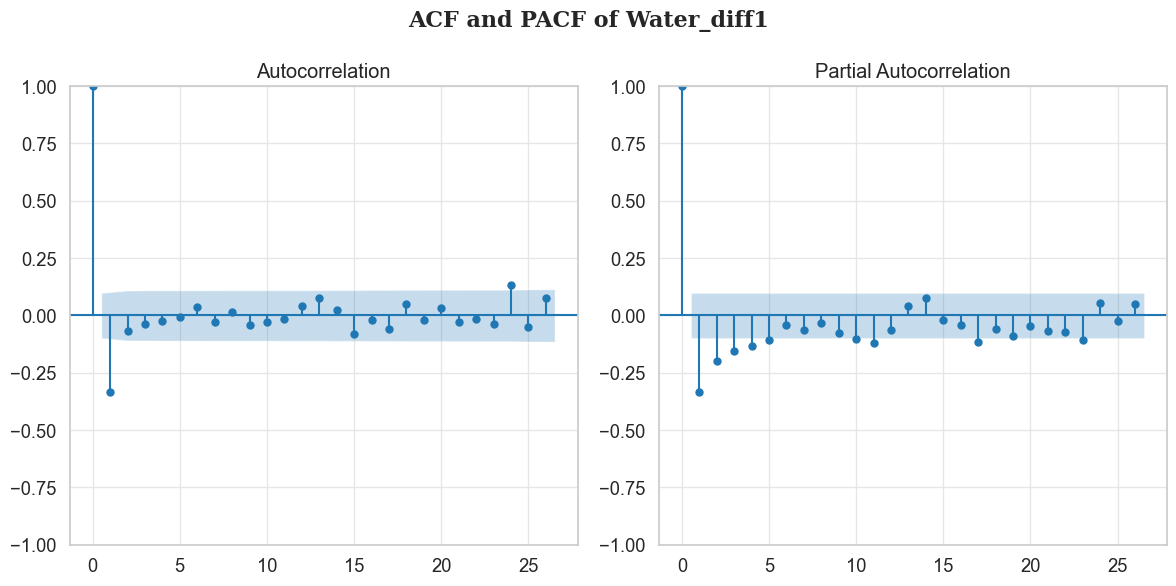

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_acf_pacf(df, 'Water_diff1', ax=ax)
plt.tight_layout()
plt.show()

**Observaions**:
- It seems that the correlation at lag 1 is significant and positive for both plots
- The ACF shows a sharper cutoff compared to PACF. In particular, ACF has 1 significant spike while PACF has 5
- This means that the differenced series displays a MA(1) signature which suggests that we should set the order of q to be 1 => i.e. fit an ARIMA (0,1,1) model

### **Model Implementation**

Before fitting the model, we will be splitting the time series into training and testing sets. 

Time series splits is slightly different from the usual train test splits since time series splits requires that the test datasets are always more recent than train datasets which is more realistic since we will not be able to train on future data

However, the time series split also has some drawbacks since it might cause overfitting to the test sets depending on where the data is split (this means that choosing where to split plays a part in the validation result). As such, we will be using what is known as walk-foward validation for more robust results

In [35]:
def walk_forward_validation(train, test, model, **kwargs):


    data = np.append(train, test)
    predictions = np.array([])
    predictions_ciUpper = np.array([])
    predictions_ciLower = np.array([])

    res = {}

    tscv = TimeSeriesSplit(n_splits=len(test), test_size=1)

    for i, (train_index, test_index) in enumerate(tscv.split(data)):
        train_window = data[train_index]

        model_fit = model(train_window, **kwargs).fit()
        fcast = model_fit.get_forecast().summary_frame()
        y_pred = fcast['mean']
        predictions = np.append(predictions, y_pred)
        predictions_ciUpper = np.append(predictions_ciUpper, fcast['mean_ci_upper'])
        predictions_ciLower = np.append(predictions_ciLower, fcast['mean_ci_lower'])
    
    model_fit = model(np.append(train, test), **kwargs).fit()

    res['insample_pred'] = np.array(model_fit.get_prediction(start=0, end=len(train)-1).summary_frame()['mean'])
    res['pred'] = predictions
    res['ci_lower'] = predictions_ciLower
    res['ci_upper'] = predictions_ciUpper
    res['AIC'] = model_fit.aic
    res['BIC'] = model_fit.bic

    return res

We will be splitting our dataset into train, validation and test. We will leave the test part of the dataset out and it will only be used at the end to evaluate the different models after all tunings are complete. 
We will use the train and validation set of the dataset for walk forward cross-validation.

The rationale behind this is that similar to how the learned parameters of a model can overfit, it is also possible to overfit the hyperparameters of the model. By using splitting the dataset into three subsets, we can tune the hyperparameters using the train and validation set and use the test set to check for any problems.

<br>

We will be splitting the time series manually at around 80/20 split for the initial train and test. We will then be further splitting the train into train and validation at around 40/60 (since the validation subset will be slowly added into the train subset during walk forward validation). The time series will be split manually to ensure that a year's worth of data won't have different months being split into two different subsets

In [36]:
X_train, X_test = df['Date'][df['Date'] < '2018-01-01'], df['Date'][df['Date'] >= '2018-01-01']
X_train, X_val = X_train[X_train < '2000-01-01'], X_train[X_train >= '2000-01-01']

print(X_train.shape, X_val.shape, X_test.shape)

(120,) (216,) (61,)


#### **Univariate Time Series**

When it comes to univariate time series, there are two common models, ARIMA and SARIMAX

**ARIMA(p,d,q)**
- **A**uto**R**egressive
  - Used for forecasting
  - p is the order of AR process
  - Takes advantage of autocorrelation where pth order is the correlation between values p periods apart
  - pth order Auto Regressive model: 
    $\begin{equation}
    X_t = \sum_{i=1}^{p}\psi_{i}\:X_{t-i}
    \nonumber
    \end{equation}$
    where $X_{t-i}$ are the model inputs while $\psi_{i}$ are the model parameters
- **I**ntegration Filter (Order of Differencing)
  - Inegreation filter that takes the order of differencing
- **M**oving**A**verage
  - Used for short term forecasting
  - q is the order of MA process
  - qth order Moving Average model:
    $\begin{equation}
    \varepsilon_{t} = \sum_{i=1}^{q}b_{i}\:\varepsilon_{t-i}
    \nonumber
    \end{equation}$


**SARIMAX(p,d,q) (P,D,Q,m)**

SARIMAX is very similar to ARIMA except for the fact that it has an additional seasonality component. It is used for time series that exhibit seasonality patterns

<hr>

Before fitting the orders of p and q as interpreted from the ACF and PACF plots into our model, we can use auto arima to see if the values of p and q given by auto ARIMA are similar to that of our model

In [37]:
Gas_train = df['Gas'][X_train.index]
Gas_val = df['Gas'][X_val.index]
Gas_test = df['Gas'][X_test.index]

Electricity_train12 = df['Electricity'][X_train.index]
Electricity_val12 = df['Electricity'][X_val.index]
Electricity_test12 = df['Electricity'][X_test.index]

Water_train = df['Water'][X_train.index]
Water_val = df['Water'][X_val.index]
Water_test = df['Water'][X_test.index]

In [38]:
# Use auto arima
gas_autoarima = auto_arima(Gas_train, start_p = 0, start_q = 0, max_p = 5, max_q = 5, error_action = 'ignore', suppress_warnings = True, seasonal = False)

electricity_autoarima = auto_arima(Electricity_train12, start_p = 0, start_q = 0, max_p = 5, max_q = 5, error_action = 'ignore', suppress_warnings = True, seasonal = True, start_P = 0, start_Q = 0, max_P = 3, max_Q = 3, m = 12, stepwise = True)

water_autoarima = auto_arima(Water_train, start_p = 0, start_q = 0, max_p = 5, max_q = 5, error_action = 'ignore', suppress_warnings = True, seasonal = False)

In [39]:
gas_autoarima_res = walk_forward_validation(Gas_train, Gas_val, ARIMA, order=gas_autoarima.get_params()['order'])
electricity_autoarima_res = walk_forward_validation(Electricity_train12, Electricity_val12, SARIMAX, order=electricity_autoarima.get_params()['order'], seasonal_order=electricity_autoarima.get_params()['seasonal_order'])
water_autoarima_res = walk_forward_validation(Water_train, Water_val, ARIMA, order=water_autoarima.get_params()['order'])

In [40]:
print(f"Order for Gas: {gas_autoarima.get_params()['order']}")
print(f"Gas Train MAPE: {mean_absolute_percentage_error(Gas_train, gas_autoarima_res['insample_pred'])*100}%")
print(f"Gas Val MAPE: {mean_absolute_percentage_error(Gas_val, gas_autoarima_res['pred'])*100}%")

print('\n')

print(f"Order for Electricity: {electricity_autoarima.get_params()['order']}, Seasonal Order: {electricity_autoarima.get_params()['seasonal_order']}")
print(f"Electricity Train MAPE: {mean_absolute_percentage_error(Electricity_train12, electricity_autoarima_res['insample_pred'])*100}%")
print(f"Electricity Val MAPE: {mean_absolute_percentage_error(Electricity_val12, electricity_autoarima_res['pred'])*100}%")

print('\n')

print(f"Order for Water: {water_autoarima.get_params()['order']}")
print(f"Water Train MAPE: {mean_absolute_percentage_error(Water_train, water_autoarima_res['insample_pred'])*100}%")
print(f"Water Val MAPE: {mean_absolute_percentage_error(Water_val, water_autoarima_res['pred'])*100}%")

Order for Gas: (2, 1, 1)
Gas Train MAPE: 11.400237164564432%
Gas Val MAPE: 11.409482731287035%


Order for Electricity: (1, 0, 0), Seasonal Order: (0, 1, 1, 12)
Electricity Train MAPE: 11.788685478357305%
Electricity Val MAPE: 2.136649419088931%


Order for Water: (1, 1, 2)
Water Train MAPE: 18.767691350976683%
Water Val MAPE: 24.071885658123122%


**Observations**:
- For gas, autoarima and the ACF_PACF plot disagree on the parameter for p while the parameter for q is the same
- For electricity, autoarima and the ACF_PACF plot actually use the same seasonal order but a different order of (1, 0, 0) is used instead of the (2, 1, 3) that is interpreted from the plots
- For water, autoarima uses an AR(1) signature and an MA(2) signature instead of just having a MA(1) signature from the ACF_PACF plots
- Generally the orders from auto arima are quite different from the ones obtained from the plots. Keeping this in mind, we can check the performance and compare the performance of the different models after fitting the orders obtained from the plots

#### *1. Gas*

As indicated from the ACF and PACF plots above, we can fit an ARIMA model with order (0, 1, 1) for gas

In [41]:
res = walk_forward_validation(Gas_train, Gas_val, ARIMA, order=(0,1,1))
insample_pred = res['insample_pred']
pred = res['pred']
upperCI = res['ci_upper']
lowerCI = res['ci_lower']
AIC = res['AIC']
BIC = res['BIC']

gas_train_mape = mean_absolute_percentage_error(Gas_train, insample_pred)*100
gas_val_mape = mean_absolute_percentage_error(Gas_val, pred)*100

print(f'Train MAPE: {gas_train_mape:.2f}%')
print(f'Validation MAPE: {gas_val_mape:.2f}%')
print(f'AIC: {AIC:.2f}')
print(f'BIC: {BIC:.2f}')

Train MAPE: 11.32%
Validation MAPE: 11.89%
AIC: 1836.89
BIC: 1844.52


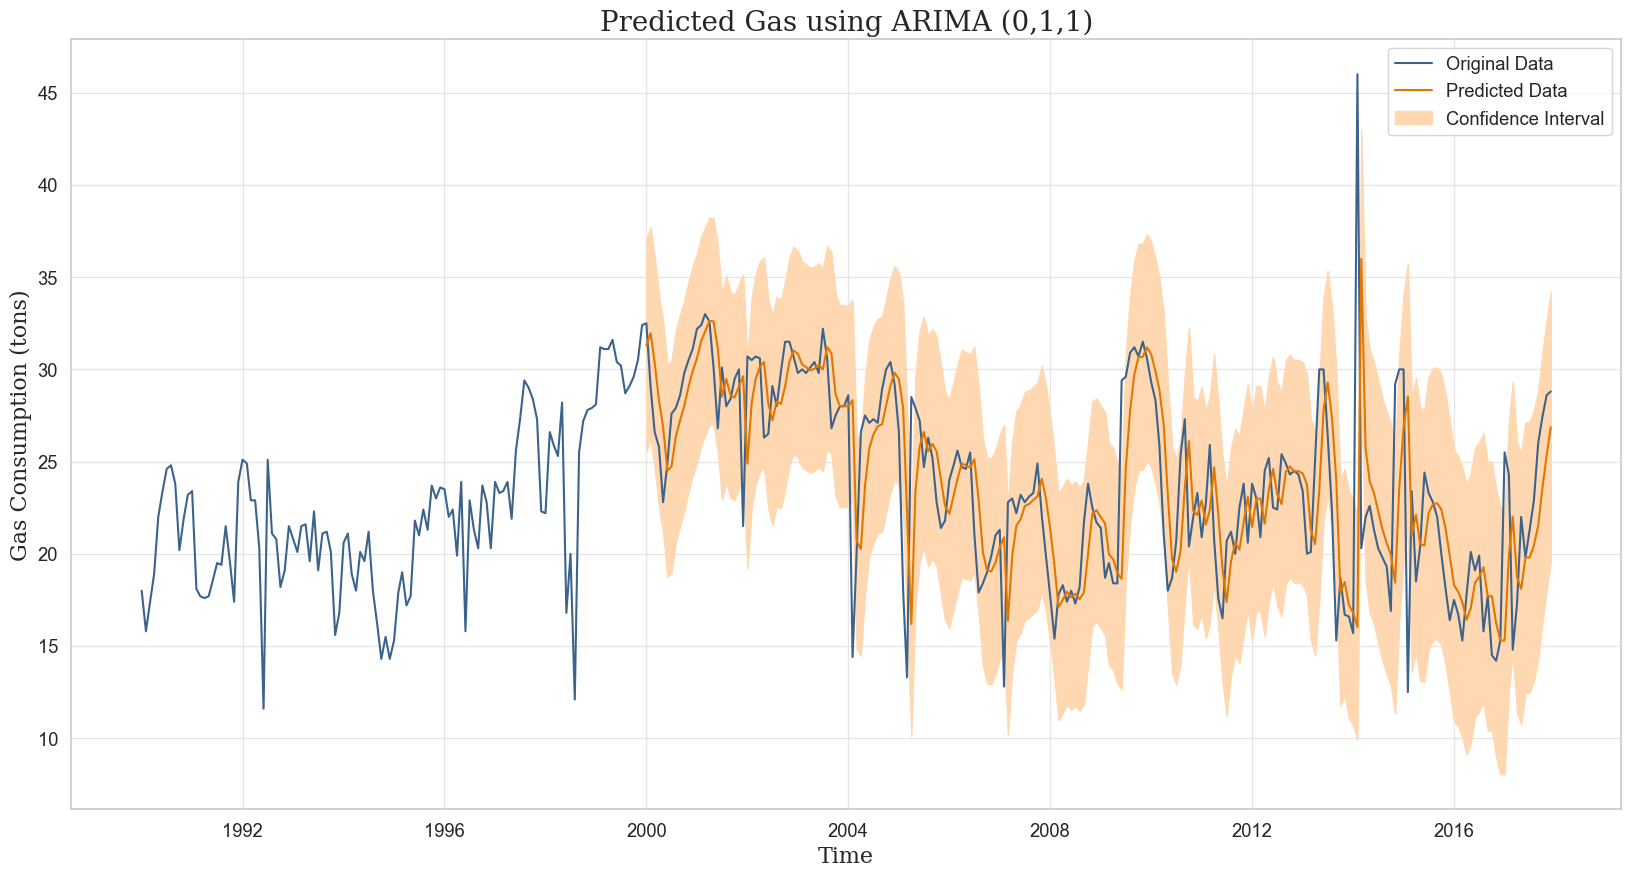

In [42]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(np.append(X_train, X_val), np.append(Gas_train, Gas_val), label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_val, pred, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Fill in the CI intervals
ax.fill_between(X_val, lowerCI, upperCI, color=sns.xkcd_rgb['light peach'], label='Confidence Interval')

# Add the title and legend
ax.set_title('Predicted Gas using ARIMA (0,1,1)', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Gas Consumption (tons)', fontsize=16, fontfamily='Serif')


plt.legend()
plt.show()

**Observations**:
- The model seems to have quite a good performance with an MAPE of 11%
- From the time series prediction plot, we can see that the predicted data quite closely matches the actual data

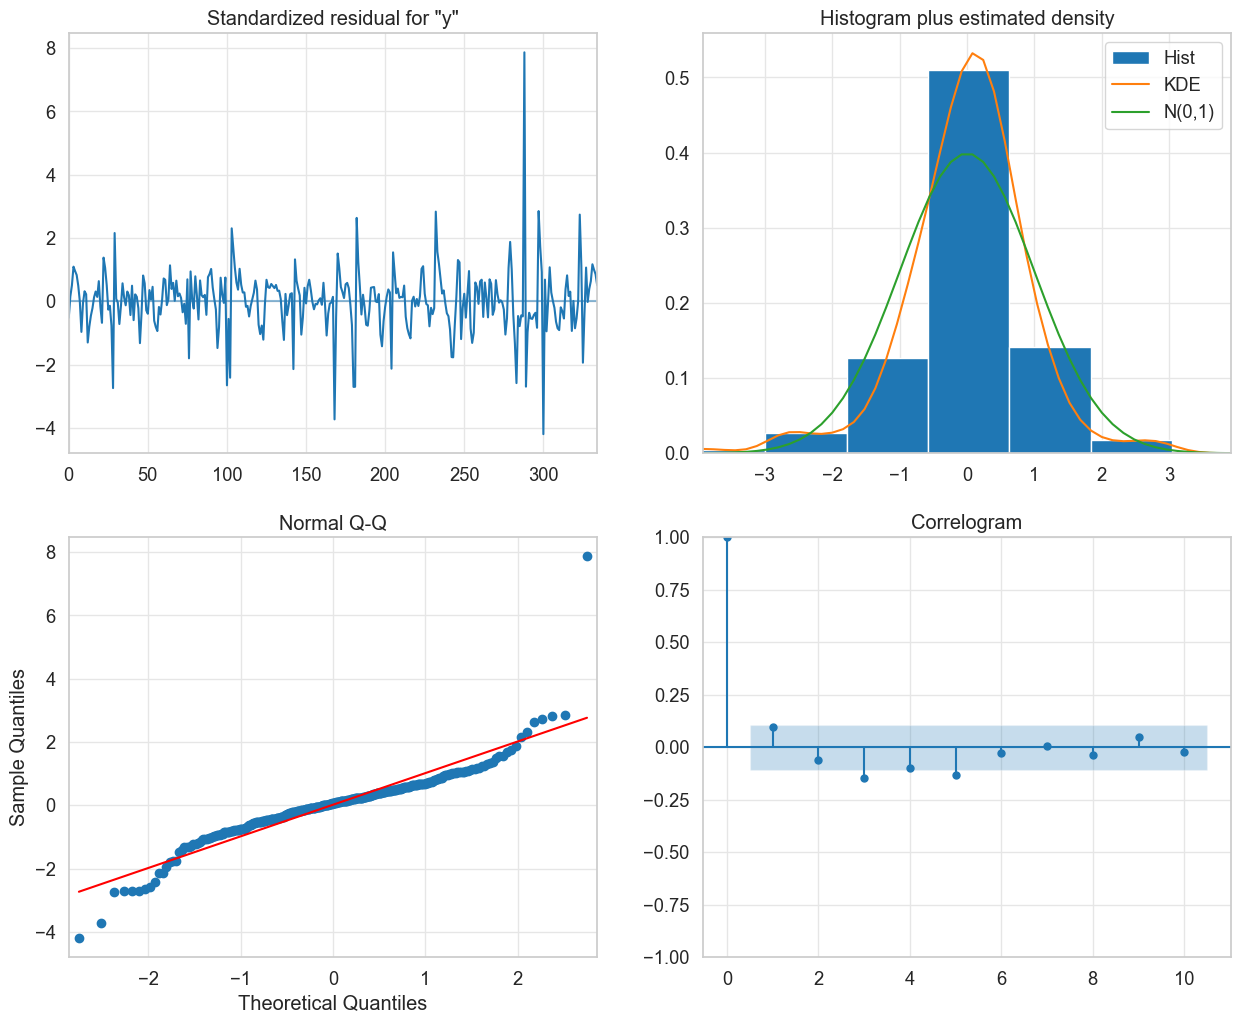

In [43]:
# Print diagnostics for the model
train = np.append(Gas_train, Gas_val)
ARIMA_model = ARIMA(train, order=(0, 1, 1))

# Plot diagnostics
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

**Observations**:
- The plot of standardized residuals are random which indicates that there are no patterns among the residuals
- We can observe that the residuals are somewhat normal from the normal Q-Q plot and the histogram of standardized residual
- From the correlogram, we can observe that most of the lags are within the non statistically significant blue region which would signify that the residuals are not correlated. However, 4 of the lags seem to have some slight significance as they lie outside the significant region

#### *2. Electricity*

As indicated from the ACF and PACF plots above, we can fit a SARIMA model with order (2, 1, 3) and seasonal order (0, 1, 1, 12) for Electricity

In [44]:
res = walk_forward_validation(Electricity_train12, Electricity_val12, SARIMAX, order=(2,1,3), seasonal_order=(0,1,1,12))
insample_pred = res['insample_pred']
y_hat = res['pred']
upperCI = res['ci_upper']
lowerCI = res['ci_lower']
AIC = res['AIC'].mean()
BIC = res['BIC'].mean()

electricity_train_mape = mean_absolute_percentage_error(Electricity_train12, insample_pred)*100
electricity_val_mape = mean_absolute_percentage_error(Electricity_val12, y_hat)*100

print(f'Train MAPE: {electricity_train_mape:.2f}%')
print(f'Validation MAPE: {electricity_val_mape:.2f}%')
print(f'AIC: {AIC:.2f}')
print(f'BIC: {BIC:.2f}')

Train MAPE: 3.43%
Validation MAPE: 2.06%
AIC: 2941.07
BIC: 2967.51


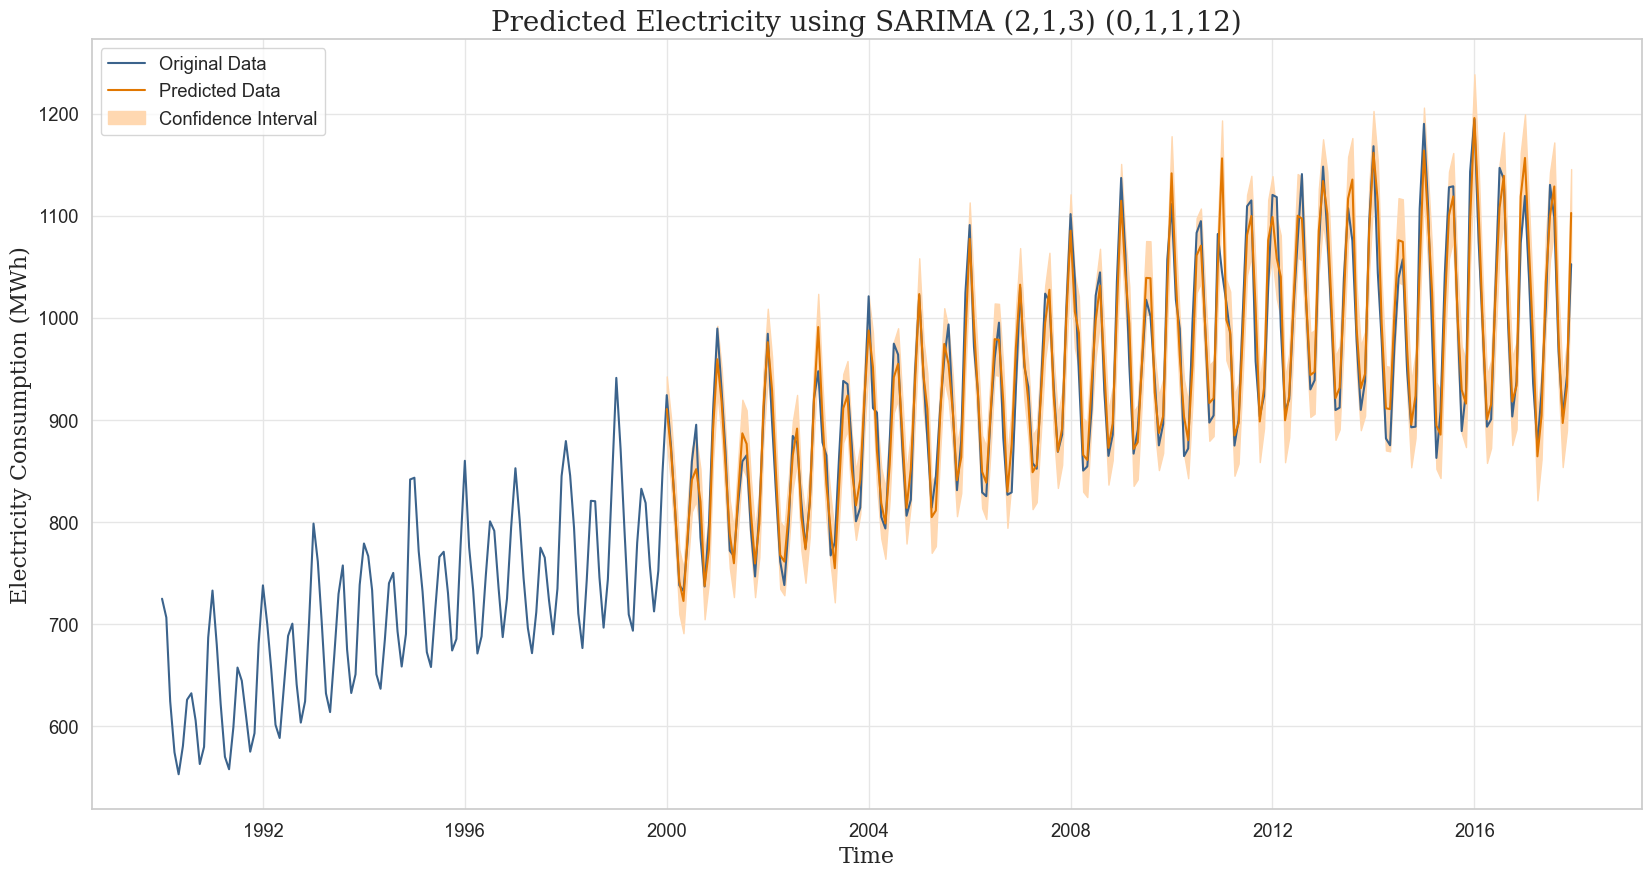

In [45]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(np.append(X_train, X_val), np.append(Electricity_train12, Electricity_val12), label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_val, y_hat, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Fill in the CI intervals
ax.fill_between(X_val, lowerCI, upperCI, color=sns.xkcd_rgb['light peach'], label='Confidence Interval')

# Add the title and legend
ax.set_title('Predicted Electricity using SARIMA (2,1,3) (0,1,1,12)', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Electricity Consumption (MWh)', fontsize=16, fontfamily='Serif')

plt.legend()
plt.show()

**Observations**:
- The model seems to have an extremely good performance with an MAPE of only 2%
- From the time series prediction plot, we can see that the predicted data almost identically matches the predicted data
- The confidence interval is also very small which suggests the model is 95% confident that the predicted value lies within that small range

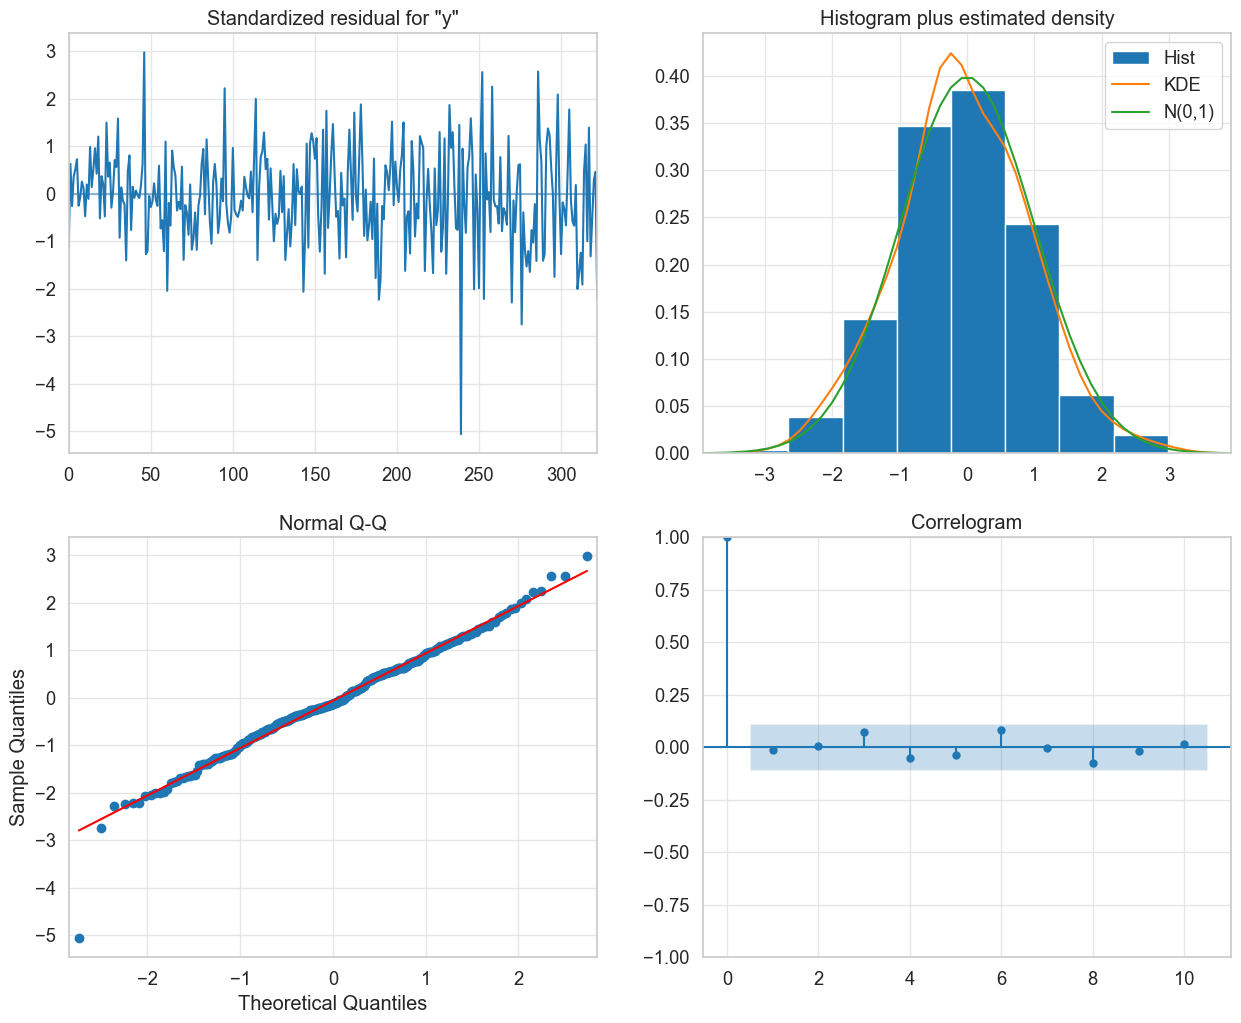

In [46]:
# Print diagnostics for the model
train = np.append(Electricity_train12, Electricity_val12)
ARIMA_model = SARIMAX(train, order=(2, 1, 3), seasonal_order=(0, 1, 1, 12))

# Plot diagnostics
ARIMA_model_fit = ARIMA_model.fit()
fig = ARIMA_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

**Observations**:
- The plot of standardized residuals are random which indicates that there are no patterns among the residuals
- We can observe that the residuals are normal from the normal Q-Q plot and the histogram of standardized residual
- From the correlogram, we can observe that most of the lags are within the non statistically significant blue region which would signify that the residuals are not correlated with only 1 of the lag having some slight significance. This means that the model is a very good fit for the data

#### *3. Water*

In [47]:
res = walk_forward_validation(Water_train, Water_val, ARIMA, order=(0,1,1))
insample_pred = res['insample_pred']
pred = res['pred']
upperCI = res['ci_upper']
lowerCI = res['ci_lower']
AIC = res['AIC']
BIC = res['BIC']

water_train_mape = mean_absolute_percentage_error(Water_train, insample_pred)*100
water_val_mape = mean_absolute_percentage_error(Water_val, pred)*100

print(f'Train MAPE: {water_train_mape:.2f}%')
print(f'Validation MAPE: {water_val_mape:.2f}%')
print(f'AIC: {AIC:.2f}')
print(f'BIC: {BIC:.2f}')

Train MAPE: 18.91%
Validation MAPE: 24.26%
AIC: 4084.79
BIC: 4092.42


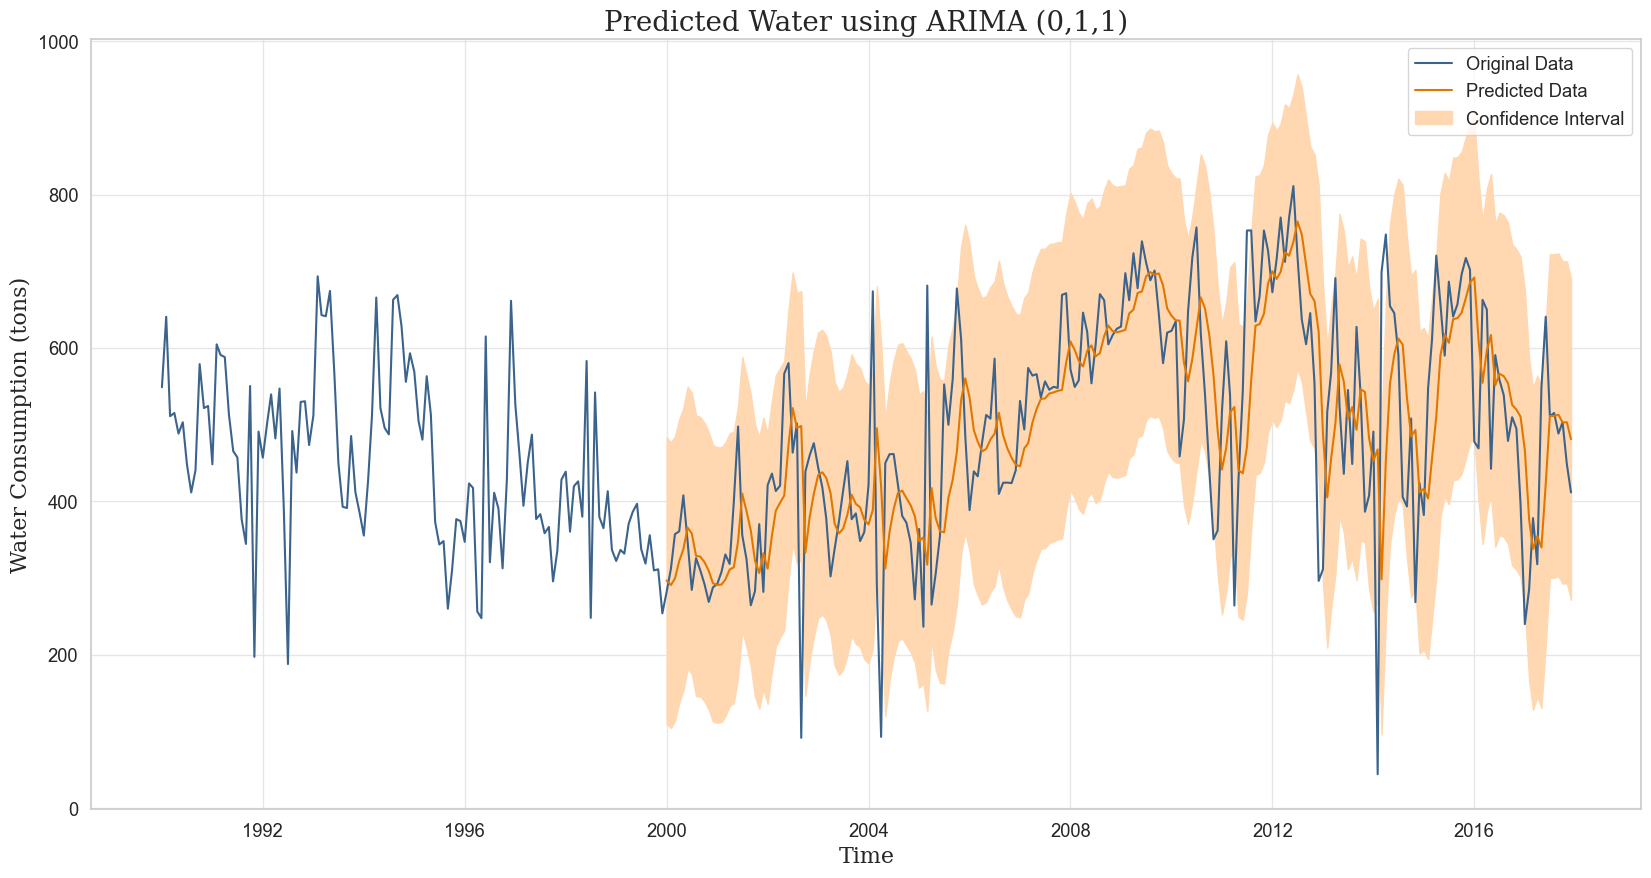

In [48]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(np.append(X_train, X_val), np.append(Water_train, Water_val), label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_val, pred, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Fill in the CI intervals
ax.fill_between(X_val, lowerCI, upperCI, color=sns.xkcd_rgb['light peach'], label='Confidence Interval')

# Add the title and legend
ax.set_title('Predicted Water using ARIMA (0,1,1)', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Water Consumption (tons)', fontsize=16, fontfamily='Serif')


plt.legend()
plt.show()

**Observations**:
- The model seems to have quite a decent with an MAPE of 24%
- From the time series prediction plot, we can see that the predicted data does not match the actual data that well for certain periods

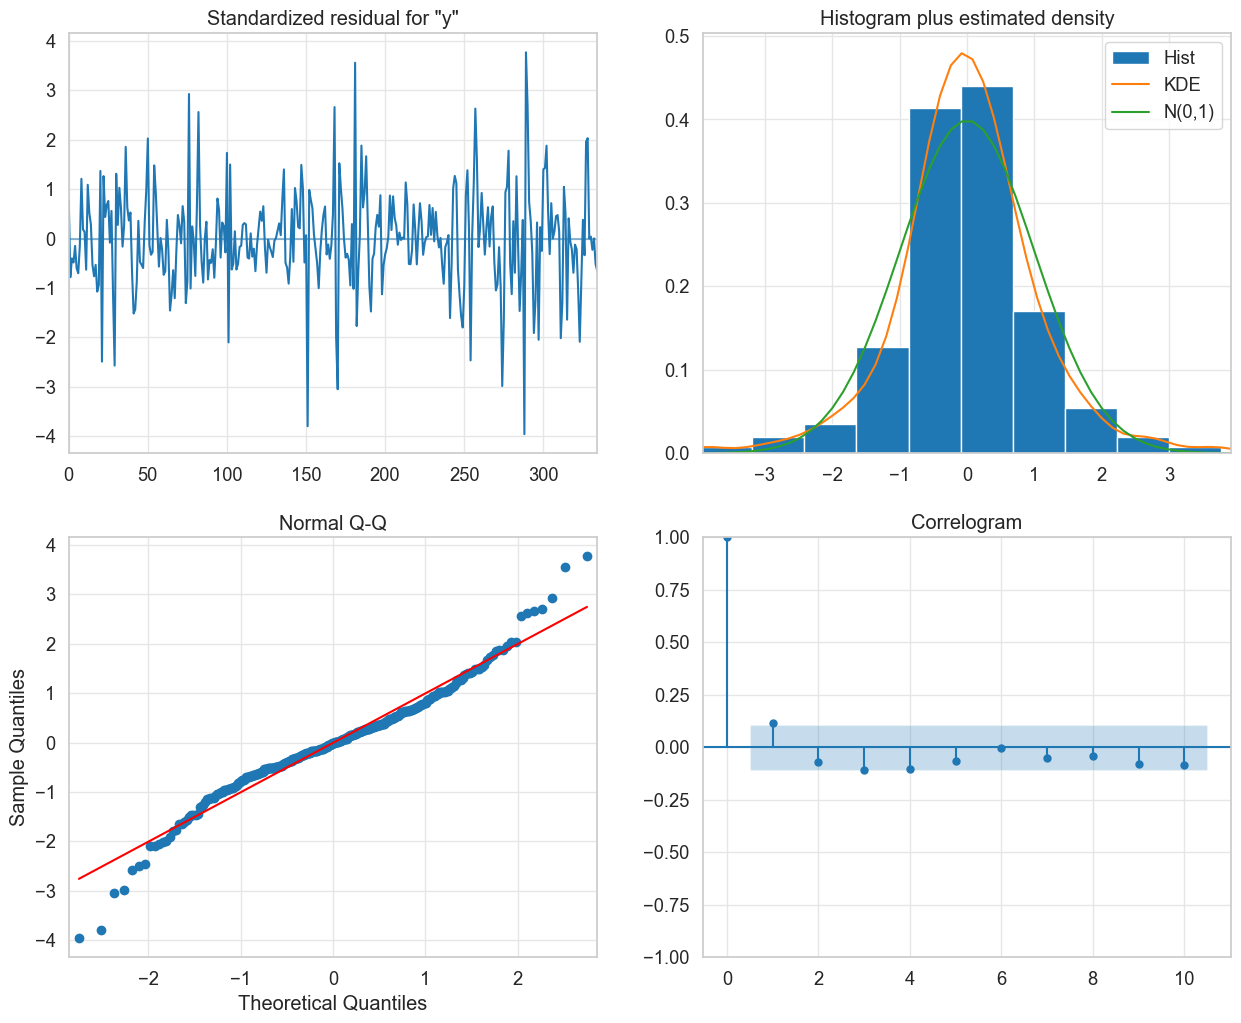

In [49]:
# Print diagnostics for the model
train = np.append(Water_train, Water_val)
ARIMA_model = ARIMA(train, order=(0, 1, 1))

# Plot diagnostics
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

**Observations**:
- The plot of standardized residuals are random which indicates that there are no patterns among the residuals
- We can observe that the residuals are somewhat normal from the normal Q-Q plot and the histogram of standardized residual
- From the correlogram, we can observe that most of the lags are within the non statistically significant blue region which would signify that the residuals are not correlated. However, 3 of the lags seem to have some slight significance as they lie outside the significant region

**AutoARIMA vs Interpretation Comparison**

In [50]:
# Autoarima
print("Autoarima" + '\n')
print(f"Order for Gas: {gas_autoarima.get_params()['order']}")
print(f"Gas Train MAPE: {mean_absolute_percentage_error(Gas_train, gas_autoarima_res['insample_pred'])*100}%")
print(f"Gas Val MAPE: {mean_absolute_percentage_error(Gas_val, gas_autoarima_res['pred'])*100}%")
print('\n')
print(f"Order for Electricity: {electricity_autoarima.get_params()['order']}, Seasonal Order: {electricity_autoarima.get_params()['seasonal_order']}")
print(f"Electricity Train MAPE: {mean_absolute_percentage_error(Electricity_train12, electricity_autoarima_res['insample_pred'])*100}%")
print(f"Electricity Val MAPE: {mean_absolute_percentage_error(Electricity_val12, electricity_autoarima_res['pred'])*100}%")
print('\n')
print(f"Order for Water: {water_autoarima.get_params()['order']}")
print(f"Water Train MAPE: {mean_absolute_percentage_error(Water_train, water_autoarima_res['insample_pred'])*100}%")
print(f"Water Val MAPE: {mean_absolute_percentage_error(Water_val, water_autoarima_res['pred'])*100}%")

print('\n')
print("----------------------------------------------------")
print('\n')

# ACF and PACF plots
print("ACF and PACF plots" + '\n')
print(f"Order for Gas: (0, 1, 1)")
print(f"Gas Train MAPE: {gas_train_mape}%")
print(f"Gas Val MAPE: {gas_val_mape}%")
print('\n')
print(f"Order for Electricity: (2, 1, 3), Seasonal Order: (0, 1, 1, 12)")
print(f"Electricity Train MAPE: {electricity_train_mape}%")
print(f"Electricity Val MAPE: {electricity_val_mape}%")
print('\n')
print(f"Order for Water: (0, 1, 1)")
print(f"Water Train MAPE: {water_train_mape}%")
print(f"Water Val MAPE: {water_val_mape}%")

Autoarima

Order for Gas: (2, 1, 1)
Gas Train MAPE: 11.400237164564432%
Gas Val MAPE: 11.409482731287035%


Order for Electricity: (1, 0, 0), Seasonal Order: (0, 1, 1, 12)
Electricity Train MAPE: 11.788685478357305%
Electricity Val MAPE: 2.136649419088931%


Order for Water: (1, 1, 2)
Water Train MAPE: 18.767691350976683%
Water Val MAPE: 24.071885658123122%


----------------------------------------------------


ACF and PACF plots

Order for Gas: (0, 1, 1)
Gas Train MAPE: 11.323752184728413%
Gas Val MAPE: 11.886015237186653%


Order for Electricity: (2, 1, 3), Seasonal Order: (0, 1, 1, 12)
Electricity Train MAPE: 3.4260198519367577%
Electricity Val MAPE: 2.060628712212678%


Order for Water: (0, 1, 1)
Water Train MAPE: 18.91122965488112%
Water Val MAPE: 24.26437898871908%


**Observations**:
- From the test results, the difference in performance between the order from auto arima and the order from the acf and pacf plots do not have that significant of a difference with the validation MAPE for all three time series being only 0.5% apart.
- Although loops through different orders to gives the optimal order, the way the orders are chosen are based on the AIC of the model when fitting the train data. As such, we can perform hyperparameter tuning later to loop through different orders and choose the optimal order based on different metrics such as MAPE

#### **Multivariate Time Series**

In Univariate Time Series, each model only consists of two variables, time and the field to forecast. 

In Multivariate Time Series, there would be multiple fields along with time. Each variable would depend not only on its past values but also has some dependency on other variables which is then used for forecasting future values

One of the most popular models for Multivariate Time Series is Vector Autoregressive Moving Average (VARMA). Unlike ARIMA, VARMA is able to understand and use the relationship between several variables which is useful for describing the dynamic behaviour of the data and potentially provide better forecasting results.

#### **Granger Causality**

The basis behind VARMA is that each of the time series in the system influences each other i.e. you can predict the series with past values of itself alongside other series in the system.

Using Granger's Causality Test is on common way to test this relationship between the different series before building the model. If a series1 has a relationship with series2 such that it can predict future values of series2, we can say that series1 Granger Causes series2

$H_{0}:$ Variable X does not Granger-cause variable Y

$H_{1}:$ Variable X Granger-causes variable Y



In [51]:
# Test for granger causality
from statsmodels.tsa.stattools import grangercausalitytests

df_subset = df[['Gas_diff1', 'Electricity_sdiff12', 'Water_diff1']]

g_matrix = pd.DataFrame(
    np.zeros((len(df_subset.columns), len(df_subset.columns))),
    columns=df_subset.columns,
    index=df_subset.columns
)

for col in g_matrix.columns:
    for row in g_matrix.index:
        test_result = grangercausalitytests(df_subset[[row, col]], maxlag=12, verbose=False)
        p_values = [round(test_result[i+1][0]['ssr_ftest'][1], 4) for i in range(12)]
        min_p_value = np.min(p_values)
        g_matrix.loc[row, col] = min_p_value

g_matrix.columns = [var + '_x' for var in df_subset.columns]
g_matrix.index = [var + '_y' for var in df_subset.columns]

display(g_matrix)

Gas_diff1_x  Electricity_sdiff12_x  Water_diff1_x
Gas_diff1_y                 1.0000                 0.3599         0.1967
Electricity_sdiff12_y       0.1150                 1.0000         0.1804
Water_diff1_y               0.0056                 0.1232         1.0000

**Observations**:
- From this matrix, only Gas Consumption granger causes Water Consumption where the p-value of the test is 0.0056

In [52]:
var_df = df[['Gas', 'Water']]

var_train = var_df.loc[X_train.index]
var_val = var_df.loc[X_val.index]
var_test = var_df.loc[X_test.index]

Another thing to note for VARMAX is that it is very resource intensive and can take quite a while to run if the values of p and q are too large. 

As such, we will start of small first where our parameters of VARMAX, will be p=2 and q=0. We will then perform hyperparameter tuning later to try and find better parameters.

In [53]:
model_fitted = VARMAX(np.append(var_train, var_val, axis=0), order=(2,0), integrate=1).fit()

**Check for Autocorrelation of Residuals**

Checking for autocorrelation of residuals is useful to determine if there is any leftover pattern in the residuals. If there is any correlation left in the residuals, then there may contain some pattern in the time series that is still left to be explained by the model.

One common way to check for serial correlation of errors can be measured using the Durbin Watson's Statistic

$\begin{equation}
DW = \frac{\sum_{t=2}^{T} ((e_{t} - e_{t-1})^{2})}{\sum_{t=1}^{T}e^{2}_{t}}
\nonumber
\end{equation}$

The value of this test statistic is between 0 and 4. A value of 2.0 indicates that there is no autocorrelation detected in the sample. Values from 0 to less than 2 point to positive autocorrelation while values from 2 to 4 means negatve autocorrelation

In [54]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted.resid)

print('Durbin-Watson Statistic: ')
for col, val in zip(var_df.columns, out):
    print(f"{col} : {val:.2f}")

Durbin-Watson Statistic: 
Gas : 2.02
Water : 2.05


**Observations**:
- Since the results are close to 2, it means that autocorrelation detected in the residuals is superficial and close to none

In [55]:
def VARMA_walk_forward_validation(train, test, model, **kwargs):
    data = np.append(train, test, axis=0)
    predictions = []

    res = {}
    # Number of steps to predict in the future. For the normal walk-forward validation, this is 1 but since VARMA takes way too long to fit, we will use 3 to speed up the prediction process
    nobs = 3
    tscv = TimeSeriesSplit(n_splits=-(len(test)//-nobs), test_size=nobs)
    for i, (train_index, test_index) in enumerate(tscv.split(data)):
        train_window = data[train_index]
        model_fit = model(endog=train_window, **kwargs).fit()

        # Make necessary changes to get the forecast for each endogenous variable
        fcast = model_fit.forecast(steps=nobs)
        df_forecast = pd.DataFrame(fcast, index=test[:nobs].index).rename(columns={0: 'Gas', 1: 'Water'})
        
        # Get necessary values from summary frame
        predictions.append(np.array(df_forecast))

    # Reformat predictions
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, predictions.shape[-1])[-len(test):]
    res['pred'] = predictions

    model_fit = model(np.append(train, test, axis=0), **kwargs).fit()
    pred = model_fit.predict(start=0, end=train.shape[0]-1)
    df_pred = pd.DataFrame(pred, index=train.index).rename(columns={0: 'Gas', 1: 'Water'})

    res['insample_pred'] = np.array(df_pred)

    res['AIC'] = model_fit.aic
    res['BIC'] = model_fit.bic
    
    return res

The assumption for VARMAX is that the data is stationary. 

Usually this means that we would have to input the differenced data into VARMA and use an invert function to invert the differenced predictions back into the normal scale of the time series using cumulative sum for each of the time series. 

However, since both our Gas and Water have the same order of differencing (d=1), we can fit the non-stationary data into VARMAX with integrate=1 and let statsmodel handle the inverting of the differenced data

In [56]:
res = VARMA_walk_forward_validation(var_train, var_val, VARMAX, order=(2,0),integrate=1)

In [57]:
gasVarma_pred, waterVarma_pred = res['pred'].T
gasVarma_insample_pred, waterVarma_insample_pred = res['insample_pred'].T

print(f"Gas Train MAPE: {mean_absolute_percentage_error(Gas_train, gasVarma_insample_pred)*100:.2f}%")
print(f"Gas Val MAPE: {mean_absolute_percentage_error(Gas_val, gasVarma_pred)*100:.2f}%")
print('\n')
print(f"Water Train MAPE: {mean_absolute_percentage_error(Water_train, waterVarma_insample_pred)*100:.2f}%")
print(f"Water Val MAPE: {mean_absolute_percentage_error(Water_val, waterVarma_pred)*100:.2f}%")
print('\n')

Gas Train MAPE: 10.86%
Gas Val MAPE: 14.96%


Water Train MAPE: 17.68%
Water Val MAPE: 27.06%




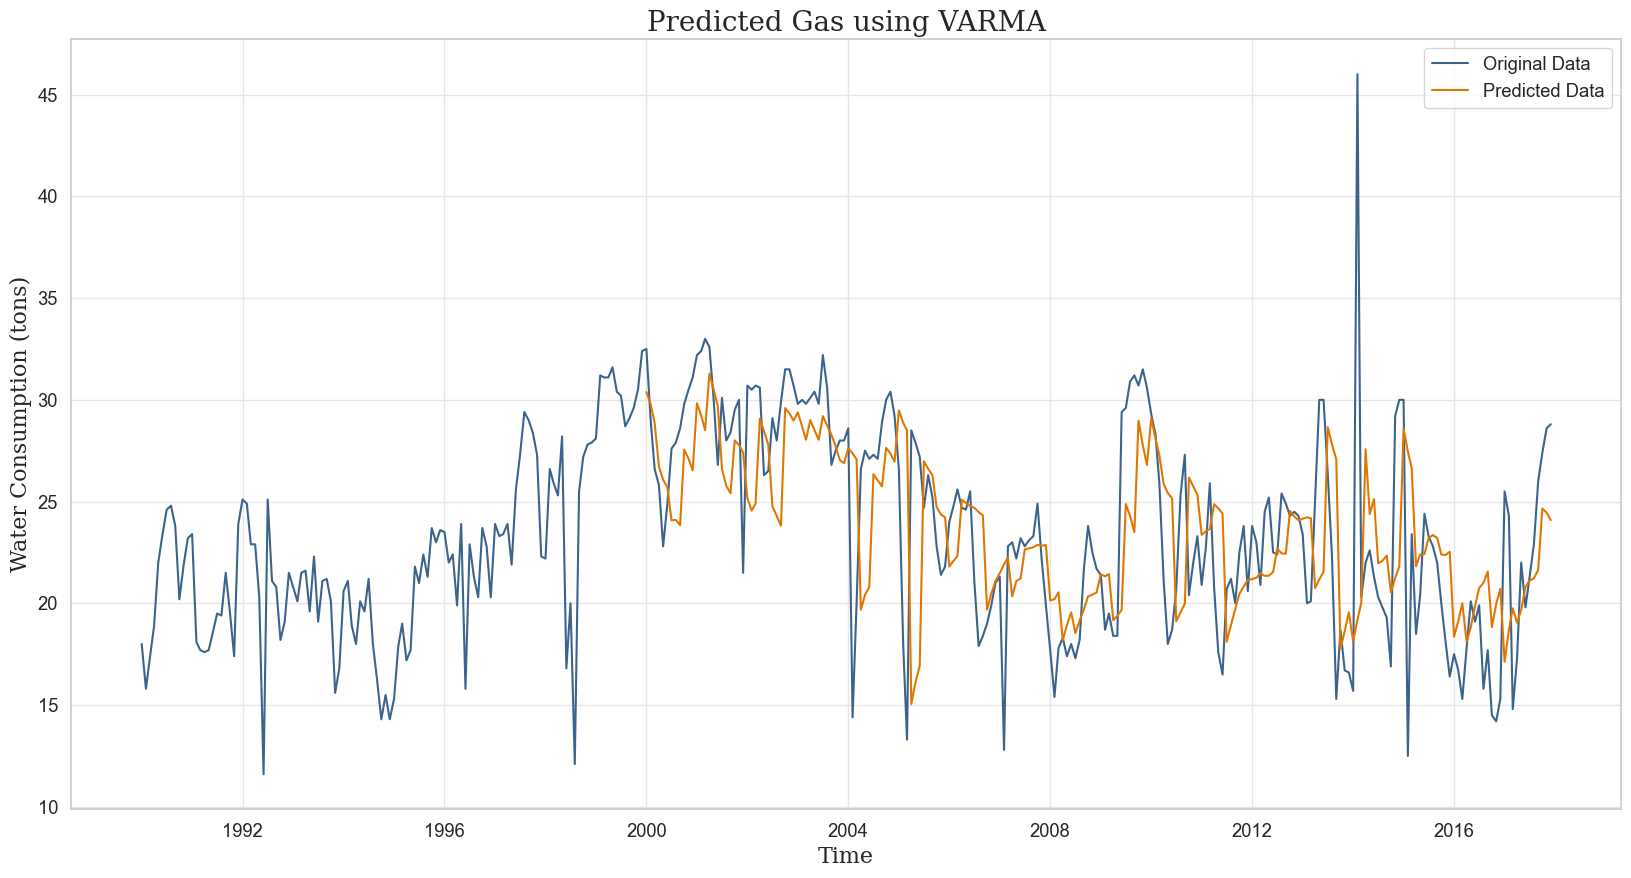

In [59]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(np.append(X_train, X_val), np.append(Gas_train, Gas_val), label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_val, gasVarma_pred, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Add the title and legend
ax.set_title('Predicted Gas using VARMA', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Water Consumption (tons)', fontsize=16, fontfamily='Serif')


plt.legend()
plt.show()

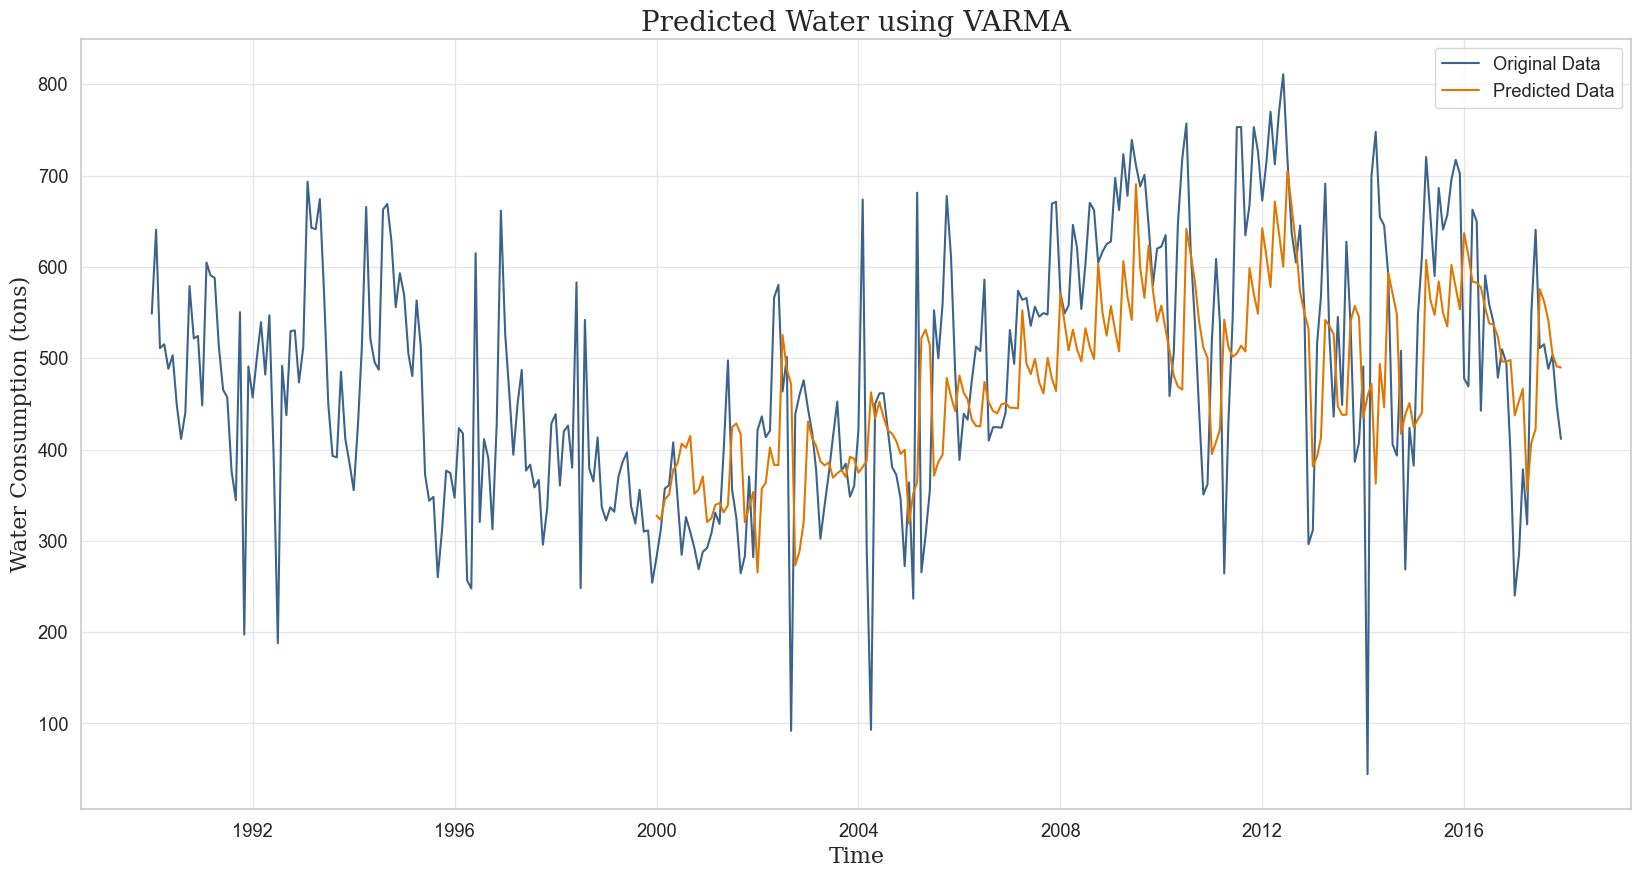

In [58]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(np.append(X_train, X_val), np.append(Water_train, Water_val), label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_val, waterVarma_pred, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Add the title and legend
ax.set_title('Predicted Water using VARMA', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Water Consumption (tons)', fontsize=16, fontfamily='Serif')


plt.legend()
plt.show()

**Observations**:
- The model seems to have quite a decent with an MAPE of 27% for water and 14% for gas. This is slightly worse than when fitting ARIMA individually for each time series
- From the time series prediction plot, we can see that the predicted data does not match the actual data that well for certain periods for both Water and Gas

Diagnostics plot for Gas


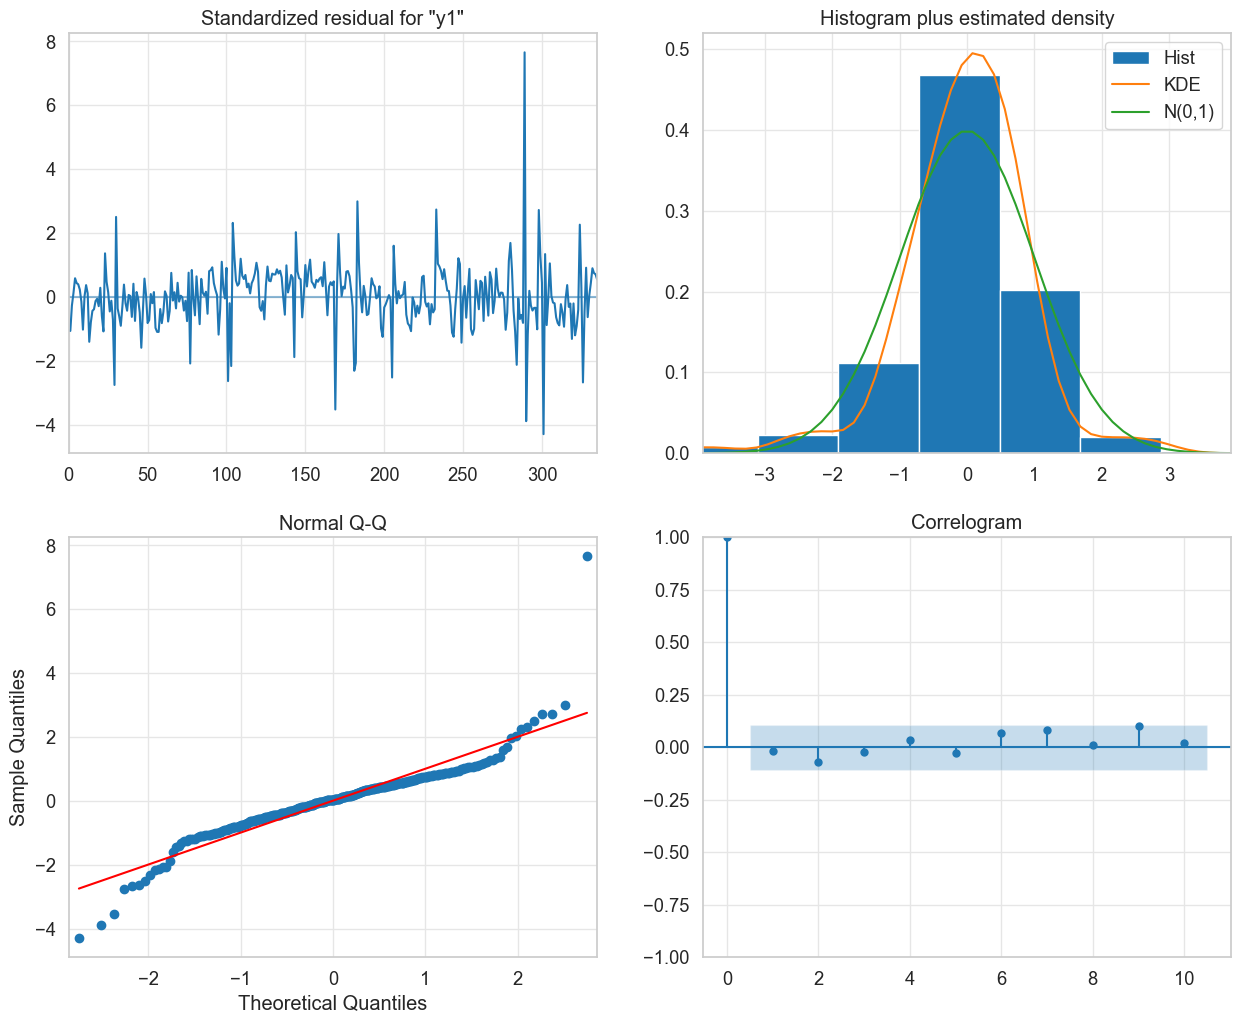

Diagnostics plot for Electricity


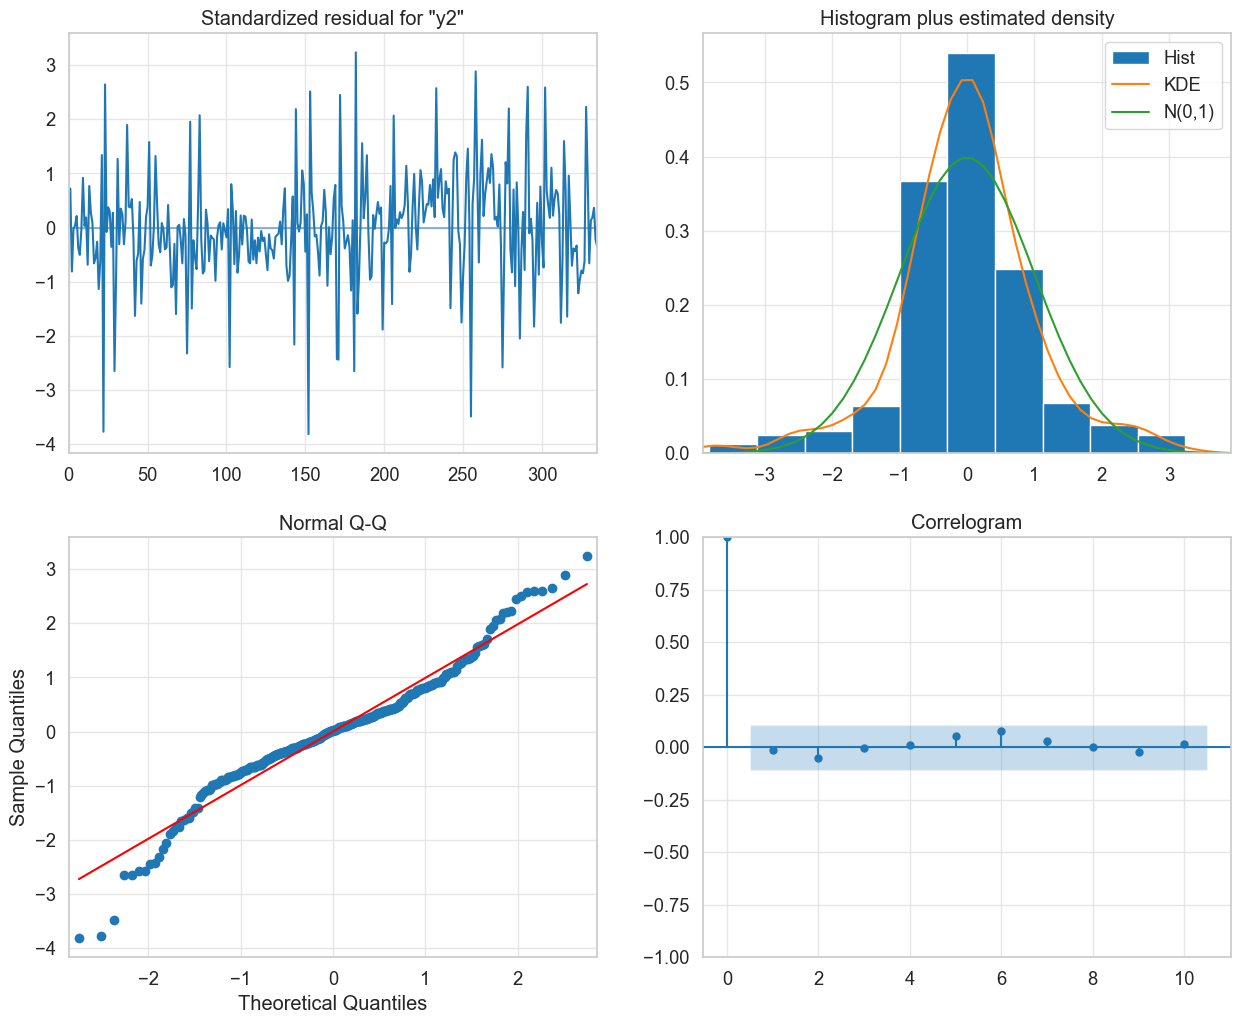

In [60]:
# Plot the diagnostics plot
data = np.append(var_train, var_val, axis=0)
VAR = VARMAX(data, order=(2,0), integrate=1).fit()

# Make a subpltot
print("Diagnostics plot for Gas")
VAR.plot_diagnostics(figsize=(15, 12), variable=0)
plt.show()
print("Diagnostics plot for Water")
VAR.plot_diagnostics(figsize=(15, 12), variable=1)
plt.show()

**Observations**:
- The plot of standardized residuals are random which indicates that there are no patterns among the residuals for both plots
- We can observe that the residuals are somewhat normal from the normal Q-Q plot and the histogram of standardized residual for both plots
- From the correlogram, we can observe that most of the lags are within the non statistically significant blue region which would signify that the residuals are not correlated with 1 of the lag having some slight significance for gas and none of the lags having any significance for water

#### **Hyperparameter Tuning**

yellow
<!-- **Akaike Information Criterion (AIC)**

AIC is used for model selection for models that fit under the maximum likelihood estimation framework (i.e. the model's parameters are estimated to try find the parameters that makes the observed data most likely).

<ins>Formula</ins>:

$\begin{equation}
AIC = 2k - 2ln(L)
\nonumber
\end{equation}$

Where,
- $k$: Number of independent features
- $L$: Log-likelihood estimate

**Bayesian Information Criterion (BIC)**

BIC, like AIC, is used for models that fit under the maximum likelihood estimation framework. Unlike AIC, BIC uses the number of examples in the training dataset 

<ins>Formula</ins>:

$\begin{equation}
AIC = k \, ln(n) - 2ln(L)
\nonumber
\end{equation}$

Where,
- $k$: Number of independent features
- $L$: Log-likelihood estimate
- $N$: Number of examples in the training dataset

The main difference between AIC and BIC is that BIC is more consistent which will select the true model with probability increasing as n increases. AIC is not as consistent because it has a chance of choosing unecessarily complex model as n becomes too large.

Another difference between AIC and BIC is that BIC considers Type I error and Type II error to be equally undesirble while AIC considers Type II error to be more undesirable than Type I errors unless n is very small -->

For our hyperparameter tuning, we will be using several metrics to evaluate the model:

`Root Mean Squared Error (RMSE)`

Mean Squared Error is the sum of error at each point (error is the square of actual - predicted at a point) divided by the total number of points. Root Mean Squared Error the square root of the Mean Squared Error.
$\begin{equation}
RMSE = \sqrt{\frac{\sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^2}{n}}
\nonumber
\end{equation}$

`Mean Absolute Percentage Error (MAPE)`

Mean Absolute Percentage Error is an evaluation metric for regression with the goal of being sensitive to relative errors
$\begin{equation}
MAPE = \sum_{i=1}^{n}\frac{|y_{i} - \hat{y_{i}}|}{max(\epsilon, |y_{i}|)}
\nonumber
\end{equation}$

the goal of $\epsilon$ is to be an arbitary small strictly positive number to avoid undefined results when y is zero

`Akaike Information Criterion (AIC)`

AIC is used for model selection for models that fit under the maximum likelihood estimation framework (i.e. the model's parameters are estimated to try find the parameters that makes the observed data most likely).
$\begin{equation}
AIC = 2k - 2ln(L)
\nonumber
\end{equation}$

where,
- $k$: Number of independent features
- $L$: Log-likelihood estimate


`Bayesian Information Criterion (BIC)`

BIC, like AIC, is used for models that fit under the maximum likelihood estimation framework. Unlike AIC, BIC uses the number of examples in the training dataset 
$\begin{equation}
AIC = k \, ln(n) - 2ln(L)
\nonumber
\end{equation}$

where,
- $k$: Number of independent features
- $L$: Log-likelihood estimate
- $N$: Number of examples in the training dataset



**ARIMA Hyperparameter tuning**

<ins>Gas Hyperparameter Tuning</ins>

In [61]:
from itertools import product
p_array = np.arange(0,3)
q_array = np.arange(0,3)

scores_df = pd.DataFrame(columns=['train_RMSE', 'val_RMSE', 'train_MAPE', 'val_MAPE', 'AIC', 'BIC'])

for p,q in (list(product(p_array, q_array))):
    try:
        res = walk_forward_validation(Gas_train, Gas_val, ARIMA, order=(p, 1, q))
    except:
        continue
    train_RMSE = mean_squared_error(res['insample_pred'], Gas_train, squared=False)
    val_RMSE = mean_squared_error(res['pred'], Gas_val, squared=False)
    train_MAPE = mean_absolute_percentage_error(Gas_train, res['insample_pred'])*100
    val_MAPE = mean_absolute_percentage_error(Gas_val, res['pred'])*100
    AIC = res['AIC']
    BIC = res['AIC']
    scores_df.loc[f"{(p,q)}"] = [train_RMSE, val_RMSE, train_MAPE, val_MAPE, AIC, BIC]

In [62]:
display(scores_df)

train_RMSE  val_RMSE  train_MAPE   val_MAPE          AIC          BIC
(0, 0)    3.593049  4.445826   11.164620  11.338647  1889.809770  1889.809770
(0, 1)    3.363035  4.179823   11.323752  11.886015  1836.888609  1836.888609
(0, 2)    3.392080  4.069913   11.659467  11.933967  1824.258521  1824.258521
(1, 0)    3.386476  4.306323   10.822288  11.598639  1856.169050  1856.169050
(1, 1)    3.348348  3.970201   11.467701  11.261039  1814.601499  1814.601499
(1, 2)    3.331769  4.003761   11.406527  11.426910  1815.526732  1815.526732
(2, 0)    3.401706  4.247770   10.994933  11.674115  1849.399510  1849.399510
(2, 1)    3.327170  4.013899   11.400237  11.409483  1815.323965  1815.323965
(2, 2)    3.320871  4.010883   11.418991  11.574217  1816.624841  1816.624841

**Observations**:
- After hyperparameter tuning, it seems that a p=1 and q=1 seems to have the best performance with the lowest validation MAPE of 11.25% and the lowest validation RMSE of 3.97
- However, it seems that our intial values of p=0 and q=1 intepretated from the ACF nad PACF plots performs rather similarly with only a slightly worse validation RMSE and validation MAPE

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  336
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -904.301
Date:                Fri, 11 Aug 2023   AIC                           1814.601
Time:                        16:50:31   BIC                           1826.044
Sample:                             0   HQIC                          1819.163
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4357      0.042     10.436      0.000       0.354       0.518
ma.L1         -0.9049      0.036    -25.451      0.000      -0.975      -0.835
sigma2        12.9128      0.503     25.661      0.0

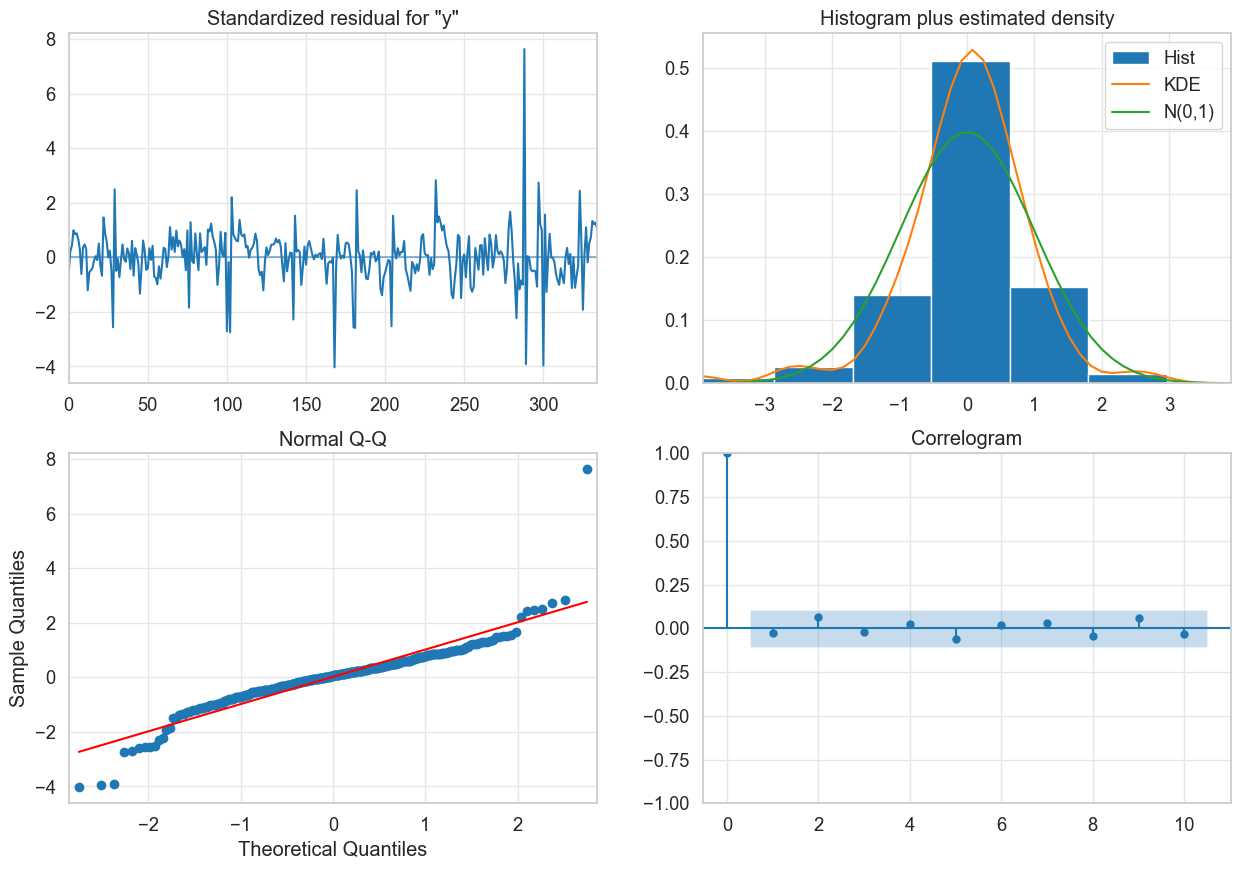

In [63]:
tuned_gas_arima = ARIMA(np.append(Gas_train, Gas_val), order=(1, 1, 1)).fit()
print(tuned_gas_arima.summary())
tuned_gas_arima.plot_diagnostics(figsize=(15, 10))
plt.show()

**Observations**:
- From the statsmodel summary, the p-value of each term ar.L1, ma.L1 and sigma2 all have a p-value of around 0.000. This means that all the terms are statistically significant since their p-values are less than 0.05
- From the standardized residuals plot, there are no obvious patterns in the residuals
- From the Histogram and Normal Q-Q plot, we can see that the residuals are more or less normal
- From the correlogram plot, we see that all the lags greater than zero are not significant (within the blue shades) which suggests no significant correlation in the residuals

In [64]:
p_array = np.arange(0,3)
q_array = np.arange(0,3)

scores_df = pd.DataFrame(columns=['train_RMSE', 'val_RMSE', 'train_MAPE', 'val_MAPE', 'AIC', 'BIC'])

for p,q in (list(product(p_array, q_array))):
    try:
        res = walk_forward_validation(Gas_train, Gas_val, ARIMA, order=(p, 1, q))
    except:
        continue
    train_RMSE = mean_squared_error(res['insample_pred'], Gas_train, squared=False)
    val_RMSE = mean_squared_error(res['pred'], Gas_val, squared=False)
    train_MAPE = mean_absolute_percentage_error(Gas_train, res['insample_pred'])*100
    val_MAPE = mean_absolute_percentage_error(Gas_val, res['pred'])*100
    AIC = res['AIC']
    BIC = res['AIC']
    scores_df.loc[f"{(p,q)}"] = [train_RMSE, val_RMSE, train_MAPE, val_MAPE, AIC, BIC]
    try:
        res = walk_forward_validation(Water_train, Water_val, ARIMA, order=(p, 1, q))
    except:
        continue
    train_RMSE = mean_squared_error(res['insample_pred'], Water_train, squared=False)
    val_RMSE = mean_squared_error(res['pred'], Water_val, squared=False)
    train_MAPE = mean_absolute_percentage_error(Water_train, res['insample_pred'])*100
    val_MAPE = mean_absolute_percentage_error(Water_val, res['pred'])*100
    AIC = res['AIC']
    BIC = res['AIC']
    scores_df.loc[f"{(p,q)}"] = [train_RMSE, val_RMSE, train_MAPE, val_MAPE, AIC, BIC]

In [65]:
display(scores_df)

train_RMSE    val_RMSE  train_MAPE   val_MAPE          AIC  \
(0, 0)  121.174912  121.776581   19.535236  24.118477  4149.008833   
(0, 1)  107.464960  113.513286   18.911230  24.264379  4084.791811   
(0, 2)  108.289033  110.486492   19.077567  24.004625  4071.703674   
(1, 0)  111.615650  118.719481   18.830633  24.821624  4113.057466   
(1, 1)  107.256363  108.833479   18.961409  23.655328  4064.485435   
(1, 2)  106.299842  109.402946   18.767691  24.071886  4065.068023   
(2, 0)  109.802701  116.370593   18.616014  24.640988  4099.707137   
(2, 1)  106.416742  109.540682   18.777984  24.073351  4065.227688   
(2, 2)  106.372525  109.914992   18.812003  24.215087  4066.865233   

                BIC  
(0, 0)  4149.008833  
(0, 1)  4084.791811  
(0, 2)  4071.703674  
(1, 0)  4113.057466  
(1, 1)  4064.485435  
(1, 2)  4065.068023  
(2, 0)  4099.707137  
(2, 1)  4065.227688  
(2, 2)  4066.865233

**Observations**:
- After hyperparameter tuning, it seems that a p=1 and q=1 seems to have the best performance with the lowest validation MAPE of 23.65% and the lowest validation RMSE of 107.26
- However, it seems that our intial values of p=0 and q=1 intepretated from the ACF nad PACF plots performs rather similarly with only a slightly worse validation RMSE and validation MAPE
- In addition, it also seems that the model performs much worse for Water than for Gas as indicated by the higher MAPE, AIC and BIC

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  336
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2029.243
Date:                Fri, 11 Aug 2023   AIC                           4064.485
Time:                        16:55:53   BIC                           4075.928
Sample:                             0   HQIC                          4069.047
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4160      0.049      8.502      0.000       0.320       0.512
ma.L1         -0.9183      0.026    -35.364      0.000      -0.969      -0.867
sigma2      1.066e+04    567.123     18.788      0.0

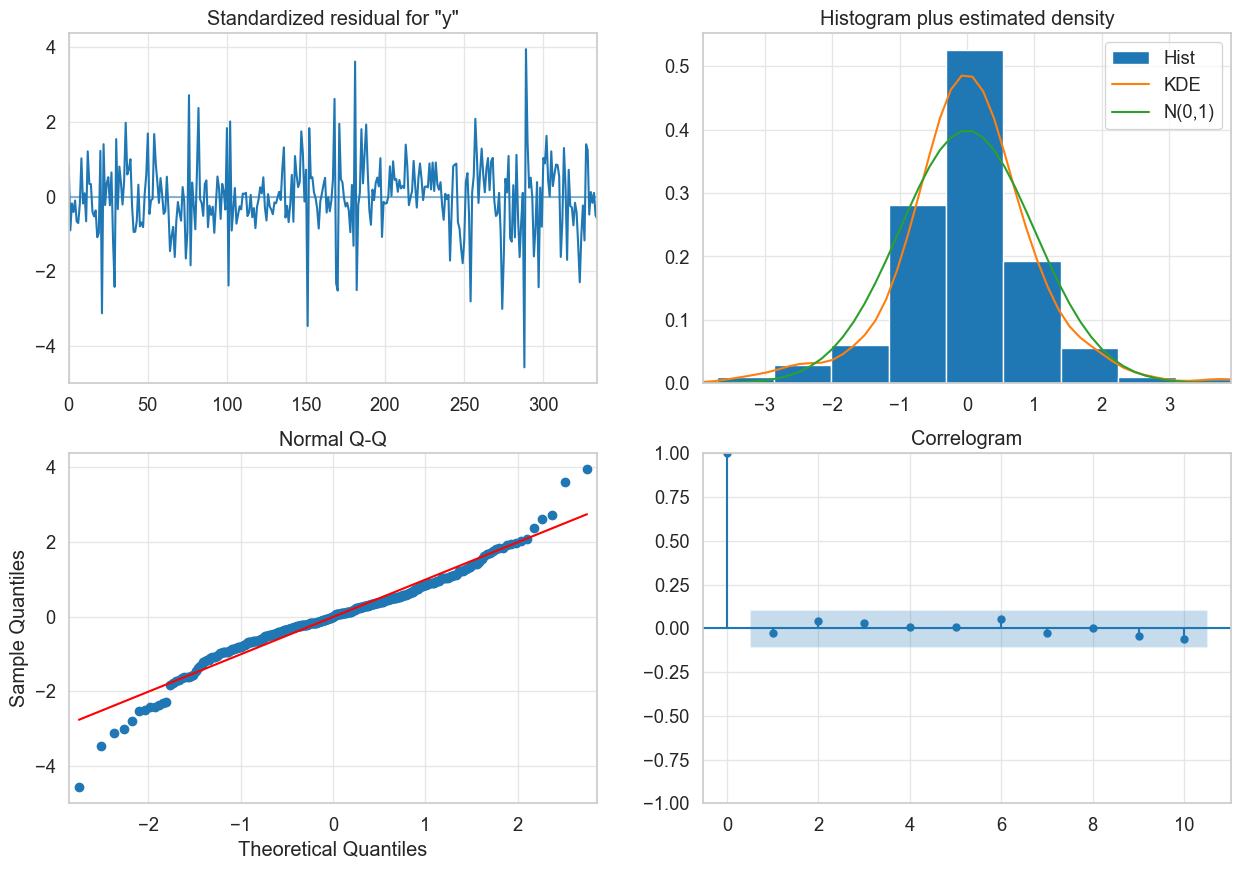

In [66]:
tuned_water_arima = ARIMA(np.append(Water_train, Water_val), order=(1, 1, 1)).fit()
print(tuned_water_arima.summary())
tuned_water_arima.plot_diagnostics(figsize=(15, 10))
plt.show()

**Observations**:
- From the statsmodel summary, the p-value of each term ar.L1, ma.L1 and sigma2 all have a p-value of around 0.000. This means that all the terms are statistically significant since their p-values are less than 0.05
- From the standardized residuals plot, there are no obvious patterns in the residuals
- From the Histogram and Normal Q-Q plot, we can see that the residuals are more or less normal
- From the correlogram plot, we see that all the lags greater than zero are not significant (within the blue shades) which suggests no significant correlation in the residuals

**SARIMAX Hyperparameter tuning**


In [67]:
P_array = np.arange(0,3)
Q_array = np.arange(0,3)

scores_df = pd.DataFrame(columns=['train_RMSE', 'val_RMSE', 'train_MAPE', 'val_MAPE', 'AIC', 'BIC'])

for P,Q in (list(product(P_array, Q_array))):
    try:
        res = walk_forward_validation(Electricity_train12, Electricity_val12, SARIMAX, order=(2, 1, 3), seasonal_order=(P, 1, Q, 12))
    except:
        continue
    train_RMSE = mean_squared_error(res['insample_pred'], Electricity_train12, squared=False)
    val_RMSE = mean_squared_error(res['pred'], Electricity_val12, squared=False)
    train_MAPE = mean_absolute_percentage_error(Electricity_train12, res['insample_pred'])*100
    val_MAPE = mean_absolute_percentage_error(Electricity_val12, res['pred'])*100
    AIC = res['AIC']
    BIC = res['AIC']
    scores_df.loc[f"{(2,3), (P,Q)}"] = [train_RMSE, val_RMSE, train_MAPE, val_MAPE, AIC, BIC]

In [68]:
display(scores_df)

train_RMSE   val_RMSE  train_MAPE  val_MAPE          AIC  \
((2, 2), (0, 0))   76.189667  29.263883    3.601270  2.395099  3039.883907   
((2, 2), (0, 1))   75.608621  24.950009    3.426020  2.060629  2941.068477   
((2, 2), (0, 2))   75.598581  25.131052    3.422016  2.079566  2942.138401   
((2, 2), (1, 0))   75.983100  27.560699    3.568334  2.209079  3000.164970   
((2, 2), (1, 1))   75.603466  24.935344    3.424303  2.066734  2942.489782   
((2, 2), (1, 2))   75.561238  25.084573    3.409172  2.087251  2941.576465   
((2, 2), (2, 1))   75.508643  24.856067    3.391093  2.036503  2936.204822   
((2, 2), (2, 2))   75.547386  24.916587    3.401598  2.059192  2933.576184   

                          BIC  
((2, 2), (0, 0))  3039.883907  
((2, 2), (0, 1))  2941.068477  
((2, 2), (0, 2))  2942.138401  
((2, 2), (1, 0))  3000.164970  
((2, 2), (1, 1))  2942.489782  
((2, 2), (1, 2))  2941.576465  
((2, 2), (2, 1))  2936.204822  
((2, 2), (2, 2))  2933.576184

**Observations**:
- After hyperparameter tuning, it seems that a P=2 and Q=1 seems to have the best performance in terms of RMSE and MAPE with a validation RMSE of 24.86 and a validation MAPE of 2.03%. In terms of AIC and BIC, P=2 and Q=2 seems to have a slightly better performance
- We can also see that models with no seasonal component (P=0, Q=0) and models without any SMA terms (Q=0) seem to perform worse with an MAPE of 2.40% and 2.21% respectively. This implies that the seasonal moving average component is playing an important role in explaining the variations and patterns present in the data

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  336
Model:             SARIMAX(2, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1459.102
Date:                              Fri, 11 Aug 2023   AIC                           2936.205
Time:                                      19:24:14   BIC                           2970.204
Sample:                                           0   HQIC                          2949.777
                                              - 336                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6872      0.143     -4.813      0.000      -0.967      -0.407
ar.L2          0.27

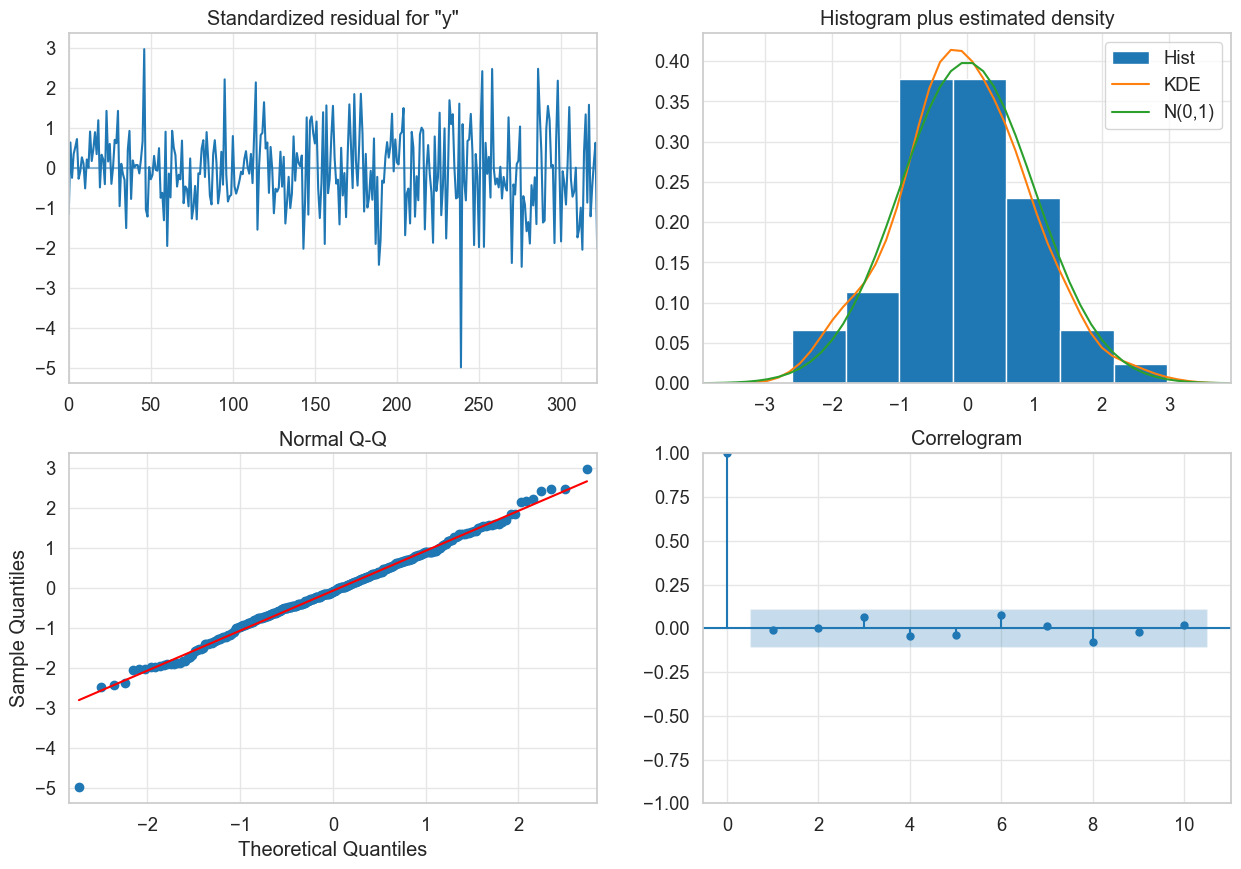

In [69]:
tuned_electricity_sarima = SARIMAX(np.append(Electricity_train12, Electricity_val12, axis=0), order=(2, 1, 3), seasonal_order=(2, 1, 1, 12)).fit()
print(tuned_electricity_sarima.summary())
tuned_electricity_sarima.plot_diagnostics(figsize=(15, 10))
plt.show()

**Observations**:
- From the statsmodel summary, the p-value of almost every term have a p-value less than 0.05 excluding one of the SAR terms (ar.S.L12). This means that most of the terms in the model are statistically significant
- From the standardized residuals plot, there are no obvious patterns in the residuals
- From the Histogram and Normal Q-Q plot, we can see that the residuals are normal with the kerndel density estimation of the residuals largely overlapping with the standard normal distribution as well as from the fact that almost all the residuals lie along the red line except for some values at the end
- From the correlogram plot, we see that all the lags greater than zero are not significant (within the blue shades) which suggests no significant correlation in the residuals

**VARIMAX Hyperparameter tuning**

In [70]:
p_array = np.arange(0,4)
q_array = np.arange(0,4)

scores_df = pd.DataFrame(columns=['gas_train_RMSE', 'gas_val_RMSE', 'gas_train_MAPE', 'gas_val_MAPE', 'water_train_RMSE', 'water_val_RMSE', 'water_train_MAPE', 'water_val_MAPE', 'AIC', 'BIC'])

for p,q in (list(product(p_array, q_array))):
    try:
        res = VARMA_walk_forward_validation(var_train, var_val, VARMAX, order=(p,q),integrate=1)
    except:
        continue
    
    gasVarma_pred, waterVarma_pred = res['pred'].T
    gasVarma_insample_pred, waterVarma_insample_pred = res['insample_pred'].T

    gas_train_RMSE = mean_squared_error(gasVarma_insample_pred, Gas_train, squared=False)
    gas_val_RMSE = mean_squared_error(gasVarma_pred, Gas_val, squared=False)
    gas_train_MAPE = mean_absolute_percentage_error(Gas_train, gasVarma_insample_pred)*100
    gas_val_MAPE = mean_absolute_percentage_error(Gas_val, gasVarma_pred)*100

    water_train_RMSE = mean_squared_error(waterVarma_insample_pred, Water_train, squared=False)
    water_val_RMSE = mean_squared_error(waterVarma_pred, Water_val, squared=False)
    water_train_MAPE = mean_absolute_percentage_error(Water_train, waterVarma_insample_pred)*100
    water_val_MAPE = mean_absolute_percentage_error(Water_val, waterVarma_pred)*100

    AIC = res['AIC']
    BIC = res['AIC']

    scores_df.loc[f"{(p,q)}"] = [gas_train_RMSE, gas_val_RMSE, gas_train_MAPE, gas_val_MAPE, water_train_RMSE, water_val_RMSE, water_train_MAPE, water_val_MAPE, AIC, BIC]

In [71]:
scores_df

gas_train_RMSE  gas_val_RMSE  gas_train_MAPE  gas_val_MAPE  \
(0, 1)        3.725280      5.026858       14.774582     18.396417   
(0, 2)        3.282878      4.909051       12.853215     17.771921   
(0, 3)        3.280095      4.856414       12.736778     17.288982   
(1, 0)        3.066729      4.595201       11.310152     14.971023   
(1, 1)        2.961908      4.592602       10.839081     14.555238   
(1, 2)        2.963760      4.602759       10.687470     14.475193   
(1, 3)        2.957546      4.551134       10.694226     14.416313   
(2, 0)        2.954243      4.652693       10.857306     14.956665   
(2, 1)        2.938383      4.668832       10.692758     14.793351   
(2, 2)        2.940618      4.621601       10.839808     14.640087   
(2, 3)        2.941203      4.563166       10.925354     14.439723   
(3, 0)        2.957155      4.666091       10.832275     14.871384   
(3, 1)        2.945055      4.669416       10.792062     14.872850   
(3, 2)        2.940605      4.621864       10.850605     14.725665   
(3, 3)        2.968962      4.573695       11.113746     14.515617   

        water_train_RMSE  water_val_RMSE  water_train_MAPE  water_val_MAPE  \
(0, 1)        104.189022      143.389632         21.701207       30.594437   
(0, 2)         99.247401      138.857486         19.883844       30.192363   
(0, 3)         96.114587      136.177206         19.581885       29.835813   
(1, 0)         98.149194      125.669199         18.823581       27.501451   
(1, 1)         92.835937      123.204268         18.103592       27.037126   
(1, 2)         93.822885      121.980038         18.559332       26.749699   
(1, 3)         94.564684      123.002994         18.665060       27.218633   
(2, 0)         92.416842      125.228500         17.683741       27.059557   
(2, 1)         92.452350      126.715811         18.339168       27.774213   
(2, 2)         91.583640      123.350749         18.003614       26.954114   
(2, 3)         92.601217      122.726363         18.437576       27.108755   
(3, 0)         92.118853      124.280648         17.768944       26.940253   
(3, 1)         92.378278      126.186309         17.974302       27.656000   
(3, 2)         93.277629      123.280824         18.420808       27.230955   
(3, 3)         93.111799      122.515819         18.372663       27.211567   

                AIC          BIC  
(0, 1)  6003.310164  6003.310164  
(0, 2)  5928.187875  5928.187875  
(0, 3)  5916.213339  5916.213339  
(1, 0)  5857.821798  5857.821798  
(1, 1)  5841.121184  5841.121184  
(1, 2)  5847.599018  5847.599018  
(1, 3)  5857.481254  5857.481254  
(2, 0)  5844.695189  5844.695189  
(2, 1)  5845.952036  5845.952036  
(2, 2)  5849.770187  5849.770187  
(2, 3)  5853.441762  5853.441762  
(3, 0)  5846.696106  5846.696106  
(3, 1)  5852.171525  5852.171525  
(3, 2)  5853.260599  5853.260599  
(3, 3)  5859.216760  5859.216760

**Observations**:
- After hyperparameter tuning, it seems that different orders all perform quite differently for the different metrics. However, the order that seems to have a good balance is p=1, q=1 which gives the lowest Validation MAPE for the Water time series and also has the lowest AIC
- We can also see that models with no AR terms (p=0) seem to perform worse with an MAPE of above 19% for water and an MAPE of above 17% for gas

                           Statespace Model Results                           
Dep. Variable:           ['y1', 'y2']   No. Observations:                  336
Model:                     VARMA(1,1)   Log Likelihood               -2907.561
                          + intercept   AIC                           5841.121
Date:                Fri, 11 Aug 2023   BIC                           5890.744
Time:                        22:32:38   HQIC                          5860.902
Sample:                             0                                         
                                - 336                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.61, 1.06   Jarque-Bera (JB):       2065.94, 60.49
Prob(Q):                        0.44, 0.30   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.27, 1.47   Skew:                      0.73, -0.32
Prob(H) (two-sided):            0.00,

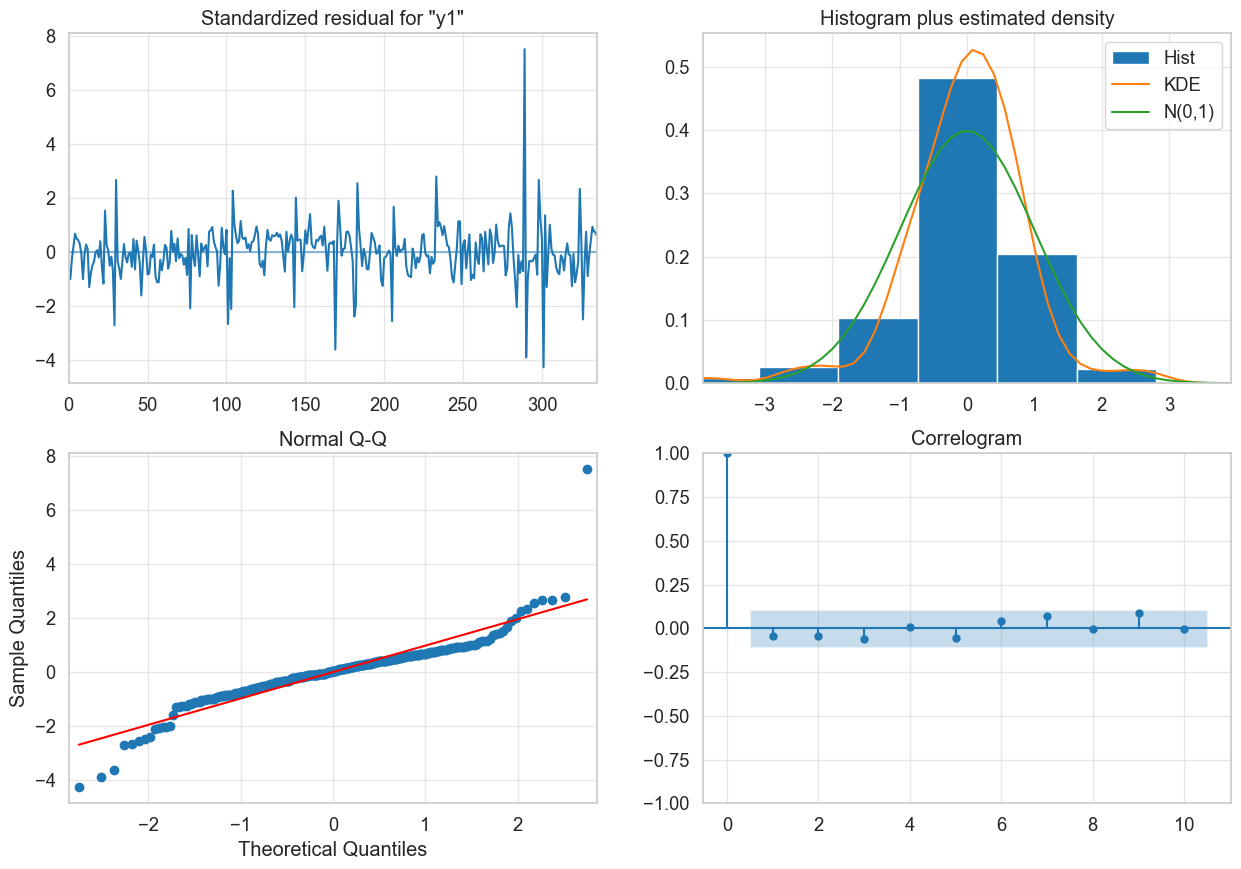

Water Diagnostic Plot


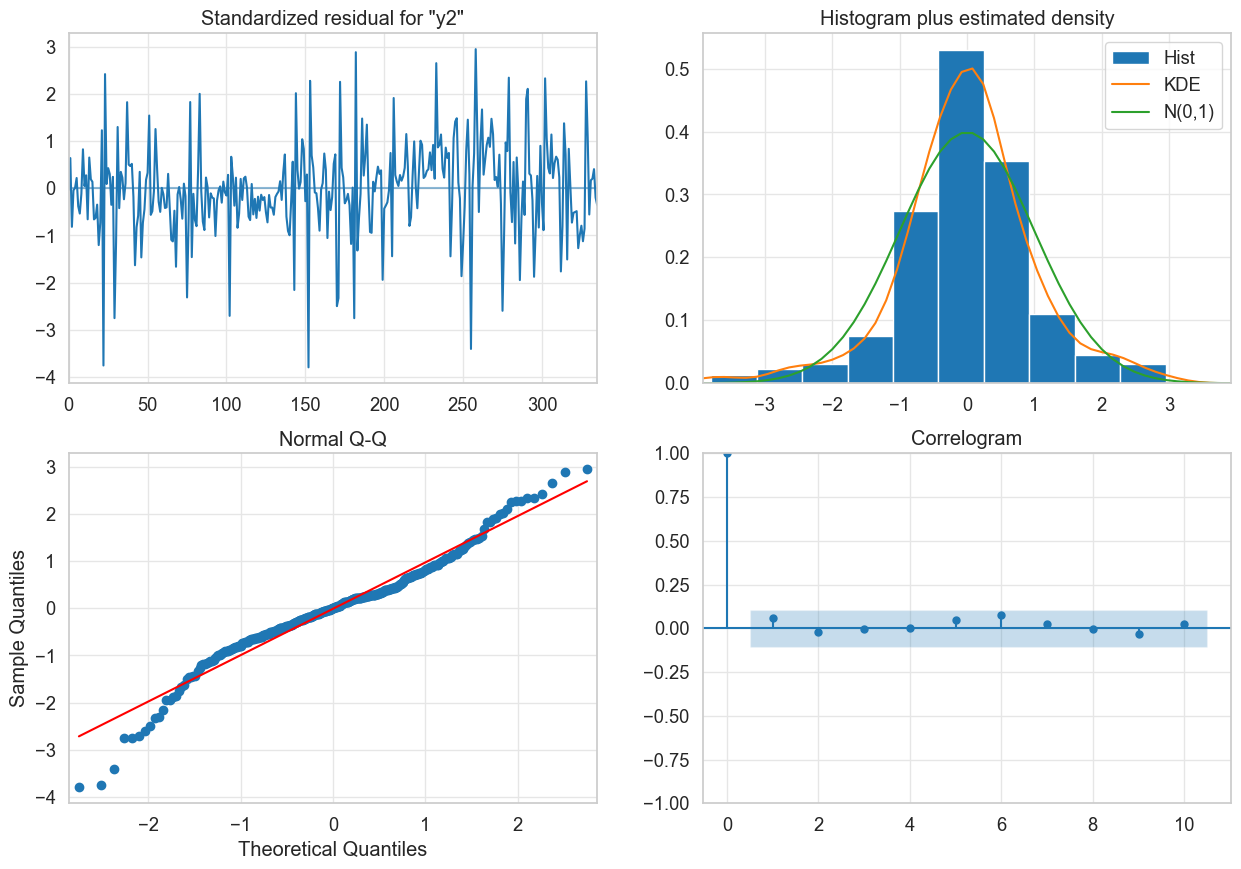

In [72]:
tuned_varma = VARMAX(np.append(var_train, var_val, axis=0), order=(1, 1)).fit()
print(tuned_varma.summary())
print("Gas Diagnostic Plot")
tuned_varma.plot_diagnostics(figsize=(15, 10), variable=0)
plt.show()
print("Water Diagnostic Plot")
tuned_varma.plot_diagnostics(figsize=(15, 10), variable=1)
plt.show()

**Observations**:
- From the summary, it seems that the terms L1 and L2 from y2 (Water) are not significant for Gas with the p-value of these terms being more than 0.05. This means that the past predictions of Water does not really help out in the future prediction of Gas.
- On the other hand, y2.L2 is the only term that is not significant for Water with a p-value of more than 0.05. This means that the predictions from the past values of gas are significant in heping predict future values of Water 
- From the standardized residuals plot, there are no obvious patterns in the residuals for both plots
- From the Histogram and Normal Q-Q plot, we can see that the residuals are more or less normal for both plots
- From the correlogram plot, we see that all the lags greater than zero are not significant for water with only one lag being slightly significant for gas which suggests no significant correlation in the residuals

#### **Model Evaluation**

In order to evaluate the tuned models, we will be using the test set of the data we split in the beginning. Since the models were trained using the train and validation set of the data, the test set act as unseen data to the model which can be used to evaluate if the model has overfitted the hyper paramters during the  model improvement step

In [73]:
def evaluate_model(model, test):
    predictions = np.array([])
    predictions_ciUpper = np.array([])
    predictions_ciLower = np.array([])

    res = {}

    for data in test:
        predictions = np.append(predictions, model.forecast(steps=1))
        predictions_ci = model.get_forecast(steps=1).conf_int()
        predictions_ciLower = np.append(predictions_ciLower, predictions_ci[0][0])
        predictions_ciUpper = np.append(predictions_ciUpper, predictions_ci[0][1])
        # add new observation to model without recalculating learned parameters
        model = model.append([data])
    
    res['predictions'] = predictions
    res['ci_upper'] = predictions_ciUpper
    res['ci_lower'] = predictions_ciLower
    res['AIC'] = model.aic
    res['BIC'] = model.bic

    return res

<ins>Gas ARIMA</ins>

In [74]:
res = evaluate_model(tuned_gas_arima, Gas_test)
predictions = res['predictions']
upperCI = res['ci_upper']
lowerCI = res['ci_lower']
aic = res['AIC']
bic = res['BIC']

print(f"Tuned ARIMA model RMSE: {mean_squared_error(Gas_test, predictions, squared=False):.2f}")
print(f"Tuned ARIMA model MAPE: {mean_absolute_percentage_error(Gas_test, predictions)*100:.2f}%")
print(f"Tuned ARIMA model AIC: {aic:.2f}")
print(f"Tuned ARIMA model BIC: {bic:.2f}")

Tuned ARIMA model RMSE: 2.64
Tuned ARIMA model MAPE: 7.61%
Tuned ARIMA model AIC: 2115.71
Tuned ARIMA model BIC: 2127.65


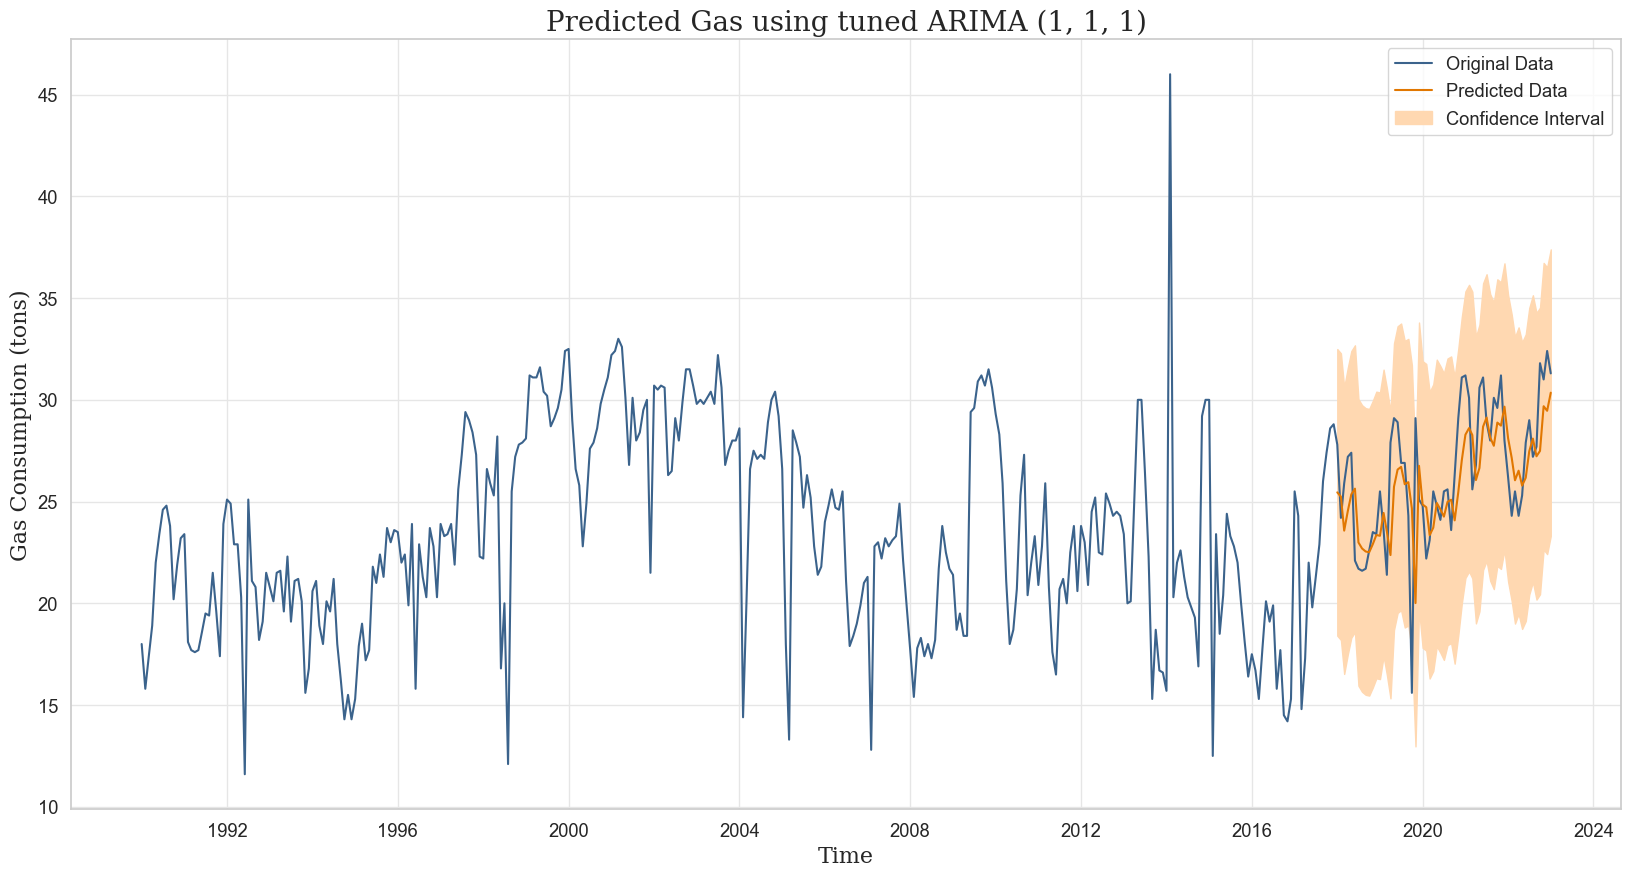

In [75]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(df['Date'], df['Gas'], label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_test, predictions, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Fill in the CI intervals
ax.fill_between(X_test, lowerCI, upperCI, color=sns.xkcd_rgb['light peach'], label='Confidence Interval')

# Add the title and legend
ax.set_title('Predicted Gas using tuned ARIMA (1, 1, 1)', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Gas Consumption (tons)', fontsize=16, fontfamily='Serif')

plt.legend()
plt.show()

**Observations**:
- The model is able to predict unforseen data quite well as shown by the time series predicted plot
- The MAPE on the test data is 7% which is an improvement over the 11% during hyperparameter tuning

<ins>Water ARIMA</ins>

In [76]:
res = evaluate_model(tuned_water_arima, Water_test)
predictions = res['predictions']
upperCI = res['ci_upper']
lowerCI = res['ci_lower']
aic = res['AIC']
bic = res['BIC']

print(f"Tuned ARIMA model RMSE: {mean_squared_error(Water_test, predictions, squared=False):.2f}")
print(f"Tuned ARIMA model MAPE: {mean_absolute_percentage_error(Water_test, predictions)*100:.2f}%")
print(f"Tuned ARIMA model AIC: {aic:.2f}")
print(f"Tuned ARIMA model BIC: {bic:.2f}")

Tuned ARIMA model RMSE: 90.79
Tuned ARIMA model MAPE: 16.58%
Tuned ARIMA model AIC: 4789.49
Tuned ARIMA model BIC: 4801.43


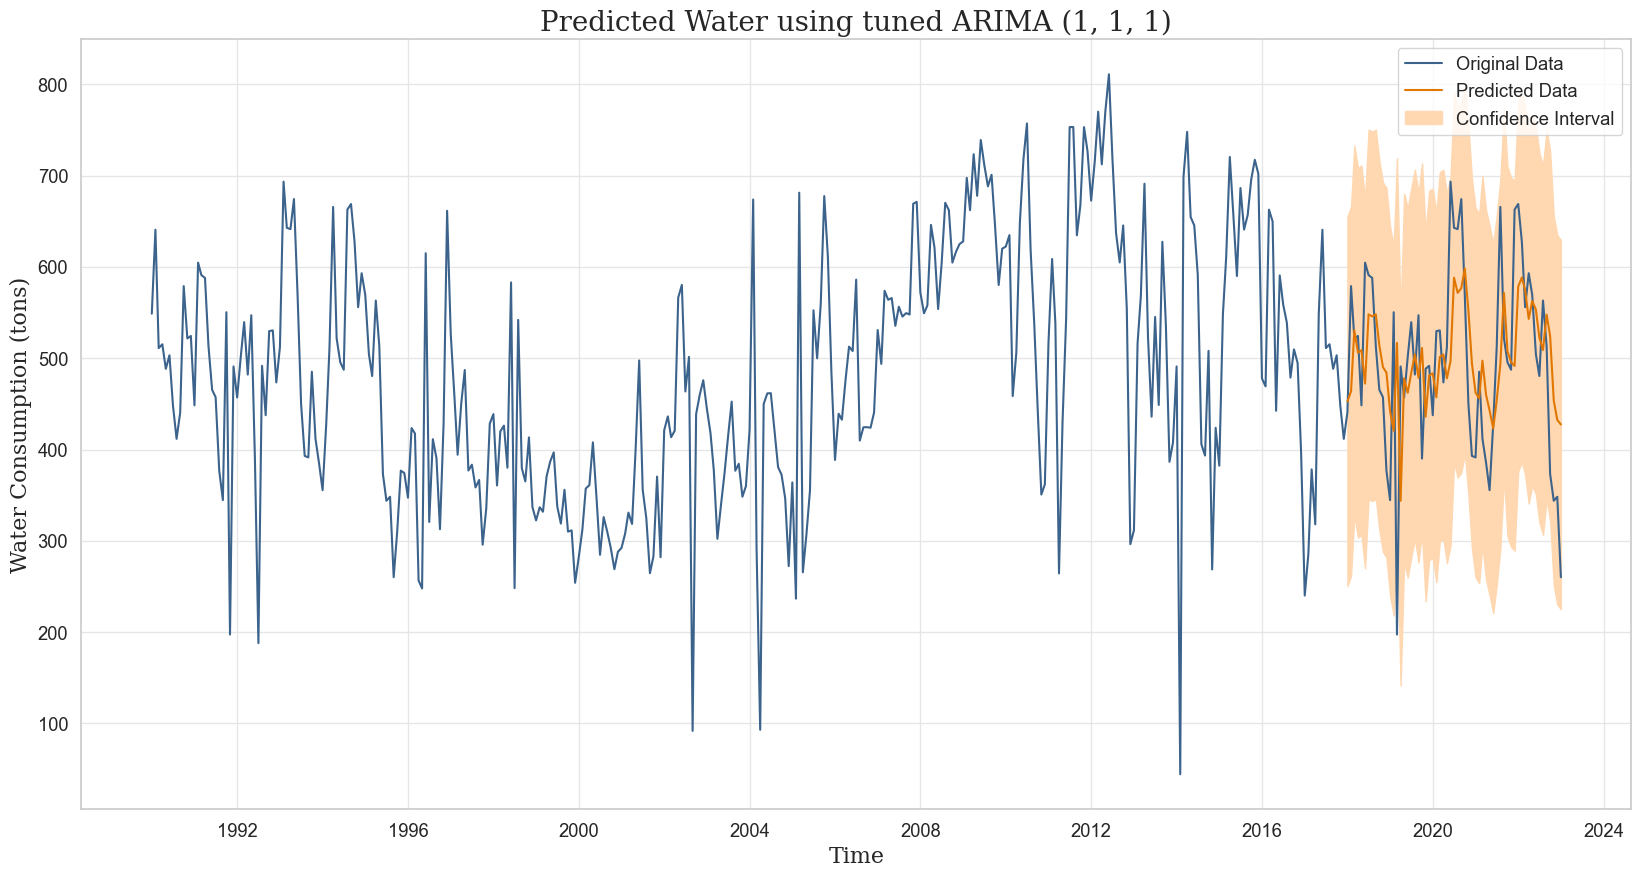

In [77]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(df['Date'], df['Water'], label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_test, predictions, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Fill in the CI intervals
ax.fill_between(X_test, lowerCI, upperCI, color=sns.xkcd_rgb['light peach'], label='Confidence Interval')

# Add the title and legend
ax.set_title('Predicted Water using tuned ARIMA (1, 1, 1)', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Water Consumption (tons)', fontsize=16, fontfamily='Serif')

plt.legend()
plt.show()

**Observations**:
- The model is able to predict unforseen data decently just like during training where the predicted time series does not completely overlap the actual data
- The MAPE on the test data is 16% which is an improvement over the 24% during hyperparameter tuning

<ins>Electricity SARIMAX</ins>

In [78]:
res = evaluate_model(tuned_electricity_sarima, Electricity_test12)
predictions = res['predictions']
upperCI = res['ci_upper']
lowerCI = res['ci_lower']
aic = res['AIC']
bic = res['BIC']

print(f"Tuned ARIMA model RMSE: {mean_squared_error(Electricity_test12, predictions, squared=False):.2f}")
print(f"Tuned ARIMA model MAPE: {mean_absolute_percentage_error(Electricity_test12, predictions)*100:.2f}%")
print(f"Tuned ARIMA model AIC: {aic:.2f}")
print(f"Tuned ARIMA model BIC: {bic:.2f}")

Tuned ARIMA model RMSE: 31.44
Tuned ARIMA model MAPE: 2.37%
Tuned ARIMA model AIC: 3551.42
Tuned ARIMA model BIC: 3586.98


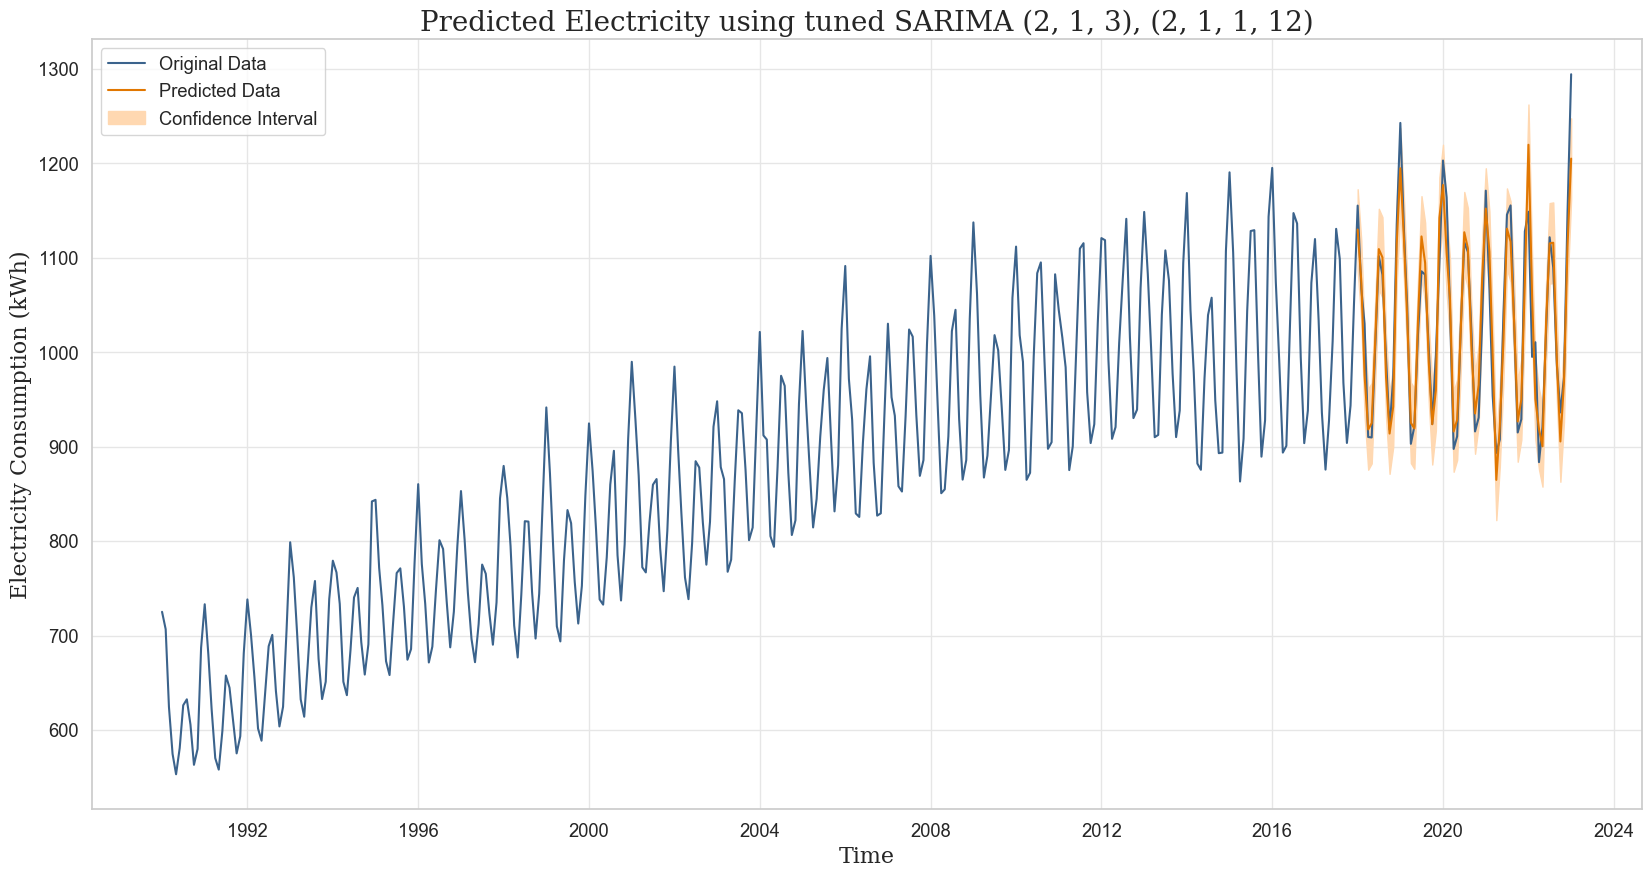

In [79]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(df['Date'], df['Electricity'], label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_test, predictions, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Fill in the CI intervals
ax.fill_between(X_test, lowerCI, upperCI, color=sns.xkcd_rgb['light peach'], label='Confidence Interval')

# Add the title and legend
ax.set_title('Predicted Electricity using tuned SARIMA (2, 1, 3), (2, 1, 1, 12)', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Electricity Consumption (kWh)', fontsize=16, fontfamily='Serif')

plt.legend()
plt.show()

**Observations**:
- The model is able to predict unforseen data very well with the predicted data almost completely overlapping the actual data except at the turning points
- The MAPE on the test data is 2.3% which dropped slightly from the 2.06% during hyperparameter tuning. However, the drop in MAPE is very small and not that significant

<ins>Gas & Water VARMAX</ins>

In [80]:
def VARMA_evaluate_model(model, test, endogs=2):
    predictions = []
    predictions_ciUpper = []
    predictions_ciLower = []

    res = {}
    for data in test.values:
        predictions.append(model.forecast(steps=1))
        predictions_ci = model.get_forecast(steps=1).conf_int()
        predictions_ciLower.append(predictions_ci[0][:int(len(predictions_ci[0])/2)])
        predictions_ciUpper.append(predictions_ci[0][int(len(predictions_ci[0])/2):])
        model = model.append([data])
    
    res['predictions'] = np.array(predictions)
    res['ci_upper'] = np.array(predictions_ciUpper)
    res['ci_lower'] = np.array(predictions_ciLower)
    res['AIC'] = model.aic
    res['BIC'] = model.bic

    return res

In [81]:
res = VARMA_evaluate_model(tuned_varma, var_test,endogs=2)
predictions = res['predictions'].reshape(-1, 2)
upperCI = res['ci_upper'].reshape(-1, 2)
lowerCI = res['ci_lower'].reshape(-1, 2)
aic = res['AIC']
bic = res['BIC']

gas_pred, water_pred = predictions.T
gas_upper, water_upper = upperCI.T
gas_lower, water_lower = lowerCI.T

print(f"Tuned ARIMA model Gas RMSE: {mean_squared_error(Gas_test, gas_pred, squared=False):.2f}")
print(f"Tuned ARIMA model Gas MAPE: {mean_absolute_percentage_error(Gas_test, gas_pred)*100:.2f}%")
print(f"Tuned ARIMA model Water RMSE: {mean_squared_error(Water_test, water_pred, squared=False):.2f}")
print(f"Tuned ARIMA model Water MAPE: {mean_absolute_percentage_error(Water_test, water_pred)*100:.2f}%")
print(f"Tuned ARIMA model AIC: {aic:.2f}")
print(f"Tuned ARIMA model BIC: {bic:.2f}")


Tuned ARIMA model Gas RMSE: 2.97
Tuned ARIMA model Gas MAPE: 8.29%
Tuned ARIMA model Water RMSE: 88.03
Tuned ARIMA model Water MAPE: 15.74%
Tuned ARIMA model AIC: 6877.52
Tuned ARIMA model BIC: 6929.32


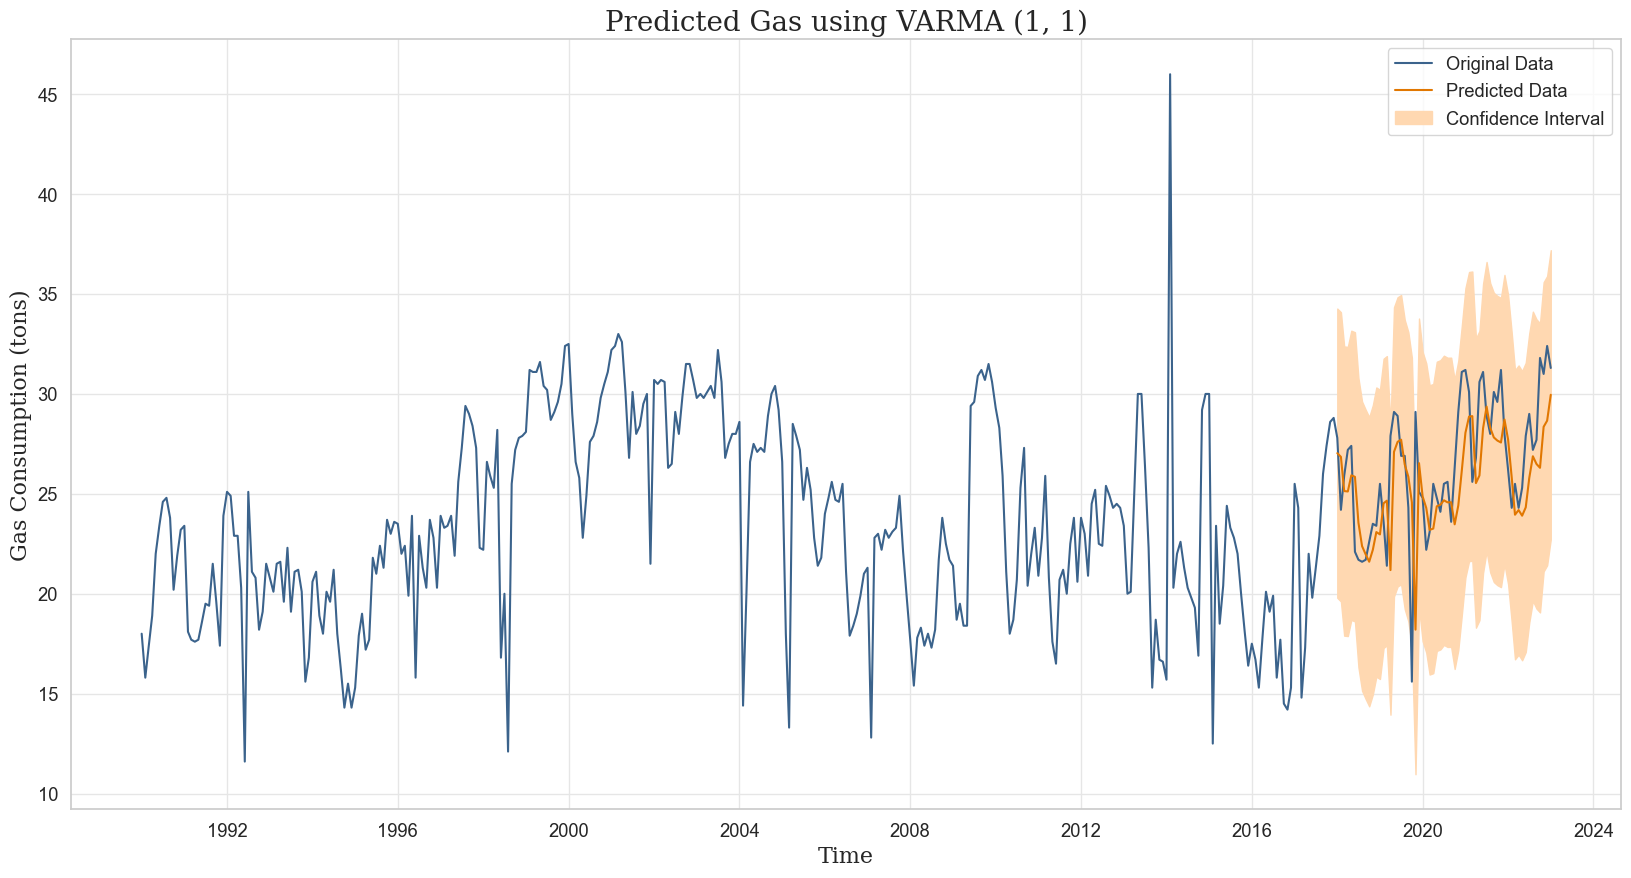

In [82]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(df['Date'], df['Gas'], label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_test, gas_pred, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Fill in the CI intervals
ax.fill_between(X_test, gas_upper, gas_lower, color=sns.xkcd_rgb['light peach'], label='Confidence Interval')

# Add the title and legend
ax.set_title('Predicted Gas using VARMA (1, 1)', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Gas Consumption (tons)', fontsize=16, fontfamily='Serif')

plt.legend()
plt.show()

**Observations**:
- The model is able to predict unforseen data decently well. However, it seem like fitting Gas into a univariate model like ARIMA seems to yield better result
- The MAPE on the test data is 8% which is an improvement over the 14% during hyperparameter tuning.

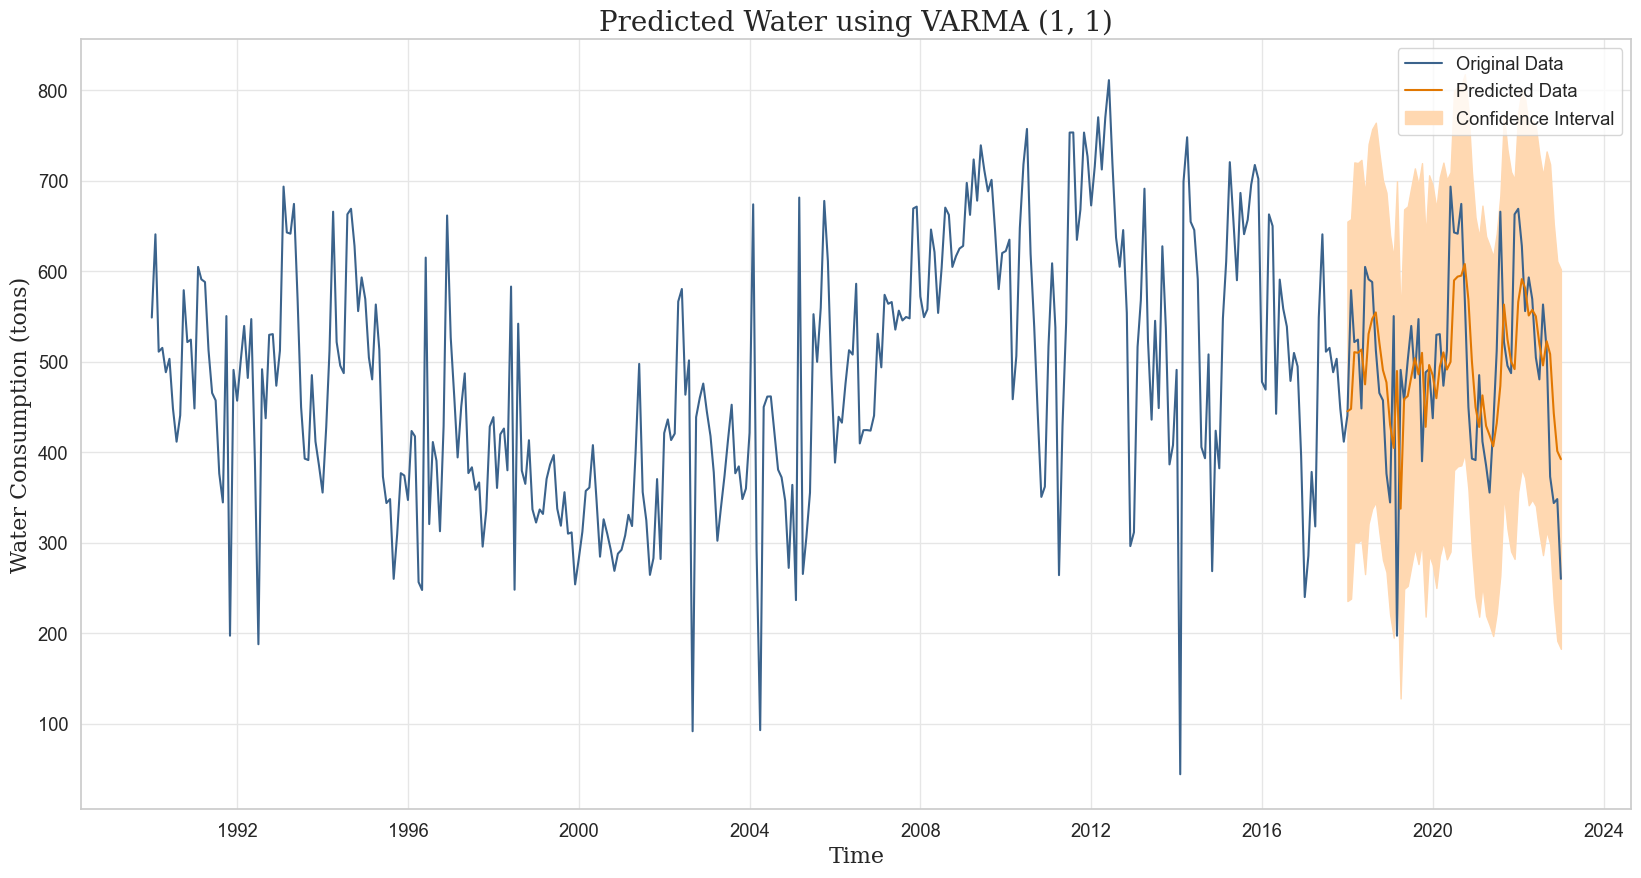

In [83]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))

# Plot the original data
ax.plot(df['Date'], df['Water'], label='Original Data', color=sns.xkcd_rgb['denim'])

# Plot the predicted data
ax.plot(X_test, water_pred, label='Predicted Data', color=sns.xkcd_rgb['pumpkin'])

# Fill in the CI intervals
ax.fill_between(X_test, water_upper, water_lower, color=sns.xkcd_rgb['light peach'], label='Confidence Interval')

# Add the title and legend
ax.set_title('Predicted Water using VARMA (1, 1)', fontsize=20, fontfamily='serif')
ax.set_xlabel('Time', fontsize=16, fontfamily='serif')
ax.set_ylabel('Water Consumption (tons)', fontsize=16, fontfamily='Serif')

plt.legend()
plt.show()

**Observations**:
- The model is able to predict unforseen data decently well and it seems like it performs slightly better compared to just fitting Water into a univariate model like ARIMA. 
- The MAPE on the test data is 15% which is an improvement over the 18% during hyperparameter tuning.
- The reason for the difference in performance between Gas and Water is likely because at the start of our Multivariate Analysis, we found out that Gas granger causes Water but the opposite is not true. This may be why using a VARMAX model with Gas and Water is able to help improve the predictions of the Water time series but it doesn't help much for the prediction of Gas